# 『5과목』 AI와 딥러닝

## 생성 모델

## Set Up

In [1]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # Windows
# matplotlib.rcParams['font.family'] = 'AppleGothic' # Mac
matplotlib.rcParams['font.size'] = 15 # 글자 크기
matplotlib.rcParams['axes.unicode_minus'] = False # 한글 폰트 사용 시, 마이너스 글자가 깨지는 현상을 해결

## 순서열 생성 모델

### Seq2Seq 모델 구현 예제

1. 데이터 준비

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 간단한 영어-프랑스어 문장 쌍
data = [
    ("Hi.", "Salut."),
    ("How are you?", "Comment ça va?"),
    ("I am fine.", "Je vais bien."),
    ("What is your name?", "Comment tu t'appelles?"),
    ("My name is John.", "Je m'appelle John."),
]

# 시작 및 종료 토큰 추가
start_token = 'start'
end_token = 'end'

# 데이터 전처리
english_sentences = [start_token + ' ' + pair[0] + ' ' + end_token for pair in data]
french_sentences = [start_token + ' ' + pair[1] + ' ' + end_token for pair in data]

# 영어 문장 토큰화
english_tokenizer = Tokenizer()
english_tokenizer.fit_on_texts(english_sentences)
english_sequences = english_tokenizer.texts_to_sequences(english_sentences)
english_maxlen = max([len(seq) for seq in english_sequences])
english_vocab_size = len(english_tokenizer.word_index) + 1
english_padded_sequences = pad_sequences(english_sequences, maxlen=english_maxlen, padding='post')

# 프랑스어 문장 토큰화
french_tokenizer = Tokenizer()
french_tokenizer.fit_on_texts(french_sentences)
french_sequences = french_tokenizer.texts_to_sequences(french_sentences)
french_maxlen = max([len(seq) for seq in french_sequences])
french_vocab_size = len(french_tokenizer.word_index) + 1
french_padded_sequences = pad_sequences(french_sequences, maxlen=french_maxlen, padding='post')

# 디코더 입력과 출력 준비
decoder_input_data = np.zeros_like(french_padded_sequences)
decoder_output_data = np.zeros((len(french_sequences), french_maxlen, french_vocab_size))

for i, seq in enumerate(french_sequences):
    for t in range(len(seq) - 1):
        decoder_input_data[i, t] = seq[t]
        decoder_output_data[i, t, seq[t + 1]] = 1


2. 모델 구축

In [3]:
# 인코더 모델
encoder_inputs = Input(shape=(english_maxlen,))
encoder_embedding = tf.keras.layers.Embedding(english_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_state=True)
_, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# 디코더 모델
decoder_inputs = Input(shape=(french_maxlen,))
decoder_embedding = tf.keras.layers.Embedding(french_vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(french_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 전체 모델
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

3. 모델 학습

In [4]:
# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 모델 학습
model.fit([english_padded_sequences, decoder_input_data], decoder_output_data,
          batch_size=64, epochs=100, validation_split=0.2)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 6)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 6, 256)            │           4,096 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 5, 256)            │           3,584 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 256), (None,      │         525,312 │ embedding[0][0]            │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ [(None, 5, 256), (None,   │         525,312 │ embedding_1[0][0],         │
│                               │ 256), (None, 256)]        │                 │ lstm[0][1], lstm[0][2]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 5, 14)             │           3,598 │ lstm_1[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,061,902 (4.05 MB)

 Trainable params: 1,061,902 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1000 - loss: 1.8447 - val_accuracy: 0.2000 - val_loss: 2.1103
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.3500 - loss: 1.8243 - val_accuracy: 0.2000 - val_loss: 2.1103
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.2500 - loss: 1.8031 - val_accuracy: 0.2000 - val_loss: 2.1100
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2500 - loss: 1.7794 - val_accuracy: 0.2000 - val_loss: 2.1092
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2500 - loss: 1.7514 - val_accuracy: 0.2000 - val_loss: 2.1073
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2500 - loss: 1.7171 - val_accuracy: 0.2000 - val_loss: 2.1041
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2500 - loss: 1.6736 - val_accuracy: 0.2000 - val_loss: 2.0989
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2500 - loss: 1.6178 - val_accuracy: 0.2000 - val_loss:

4. 번역 수행

In [5]:
# 인코더 모델
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 모델
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# 인덱스-단어 딕셔너리 생성
reverse_input_char_index = {i: char for char, i in english_tokenizer.word_index.items()}
reverse_target_char_index = {i: char for char, i in french_tokenizer.word_index.items()}

def decode_sequence(input_seq):
    # 상태 생성
    states_value = encoder_model.predict(input_seq)

    # 목표 시퀀스 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = french_tokenizer.word_index[start_token]

    # 시퀀스 생성 루프
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 기초로 다음 단어 생성
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' ' + sampled_char

        if (sampled_char == end_token or
           len(decoded_sentence) > french_maxlen):
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

    return decoded_sentence

# 번역 예시
for seq_index in range(len(english_sentences)):
    input_seq = english_padded_sequences[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', english_sentences[seq_index])
    print('Decoded sentence:', decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
-
Input sentence: start Hi. end
Decoded sentence:  salut
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
-
Input sentence: start How are you? end
Decoded sentence:  comment
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
-
Input sentence: start I am fine. end
Decoded sentence:  je vais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
-
Input sentence: start What is your name? end
Decoded sentence:  comment
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
-
Input sentence: start My name is John. end
Decoded sentence:  comment


## 확률적 생성 모델

### 확률적 생성 모델을 MNIST에 적용

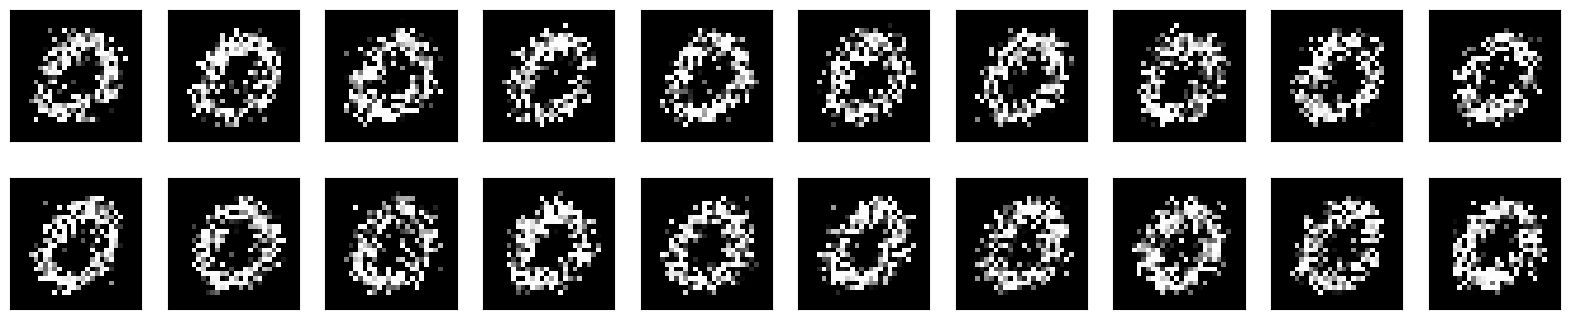

In [6]:
import numpy as np
from tensorflow.keras.datasets import mnist

# MNIST 데이터를 읽고 0 패턴만 추출
(x_train,y_train),(x_test,y_test)=mnist.load_data()
X=x_train[np.isin(y_train,[0])]

# 화소 수준의 확률 생성 모델 구축
P=np.zeros((28,28,256))
for k in range(X.shape[0]):
    for i in range(X.shape[1]):
        for j in range(X.shape[2]):
            P[i][j][X[k][i][j]]+=1
P=P/X.shape[0]

# 확률 생성 모델을 이용하여 20개 샘플을 생성
Xnew=np.zeros((20,28,28))
for i in range(20):
    for r in range(28):
        for c in range(28):
            Xnew[i][r][c]=np.random.choice(range(256),p=P[r][c])

import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))
for r in range(2):
    for c in range(10):
        plt.subplot(2,10,r*10+c+1)
        plt.imshow(Xnew[r*10+c],cmap='gray')
        plt.xticks([]); plt.yticks([])
plt.show()

### MNIST를 가지고 오토인코더를 구현

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │         100,384 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193,056 (754.12 KB)

 Trainable params: 193,056 (754.12 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3136)                │         103,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 196,097 (766.00 KB)

 Trainable params: 196,097 (766.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 159s 336ms/step - loss: 0.0451 - val_loss: 0.0074
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 308s 657ms/step - loss: 0.0065 - val_loss: 0.0049
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 237s 399ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 210s 449ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 160s 286ms/step - loss: 0.0040 - val_loss: 0.0039
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step


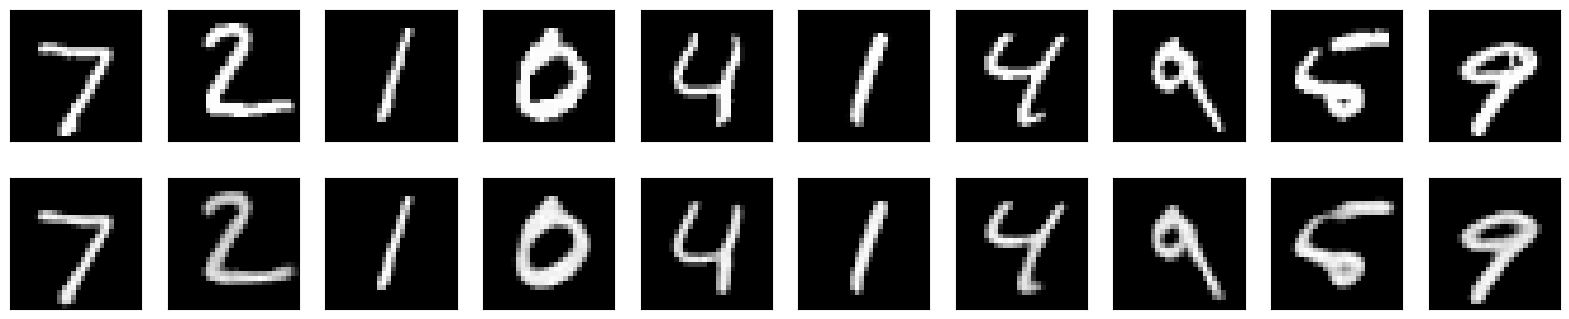

In [7]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# MNIST 데이터를 읽고 신경망에 입력할 준비
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.
x_train=np.reshape(x_train,(len(x_train),28,28,1))
x_test=np.reshape(x_test,(len(x_test),28,28,1))

zdim=32 # 잠복 공간의 차원

# 오토인코더의 인코더 부분 설계
encoder_input=Input(shape=(28,28,1))
x=Conv2D(32,(3,3),activation='relu',padding='same',strides=(1,1))(encoder_input)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x=Flatten()(x)
encoder_output=Dense(zdim)(x)
model_encoder=Model(encoder_input,encoder_output)
model_encoder.summary()

# 오토인코더의 디코더 부분 설계
decoder_input=Input(shape=(zdim,))
x=Dense(3136)(decoder_input)
x=Reshape((7,7,64))(x)
x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(32,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(1,(3,3),activation='relu',padding='same',strides=(1,1))(x)
decoder_output=x
model_decoder=Model(decoder_input,decoder_output)
model_decoder.summary()

# 인코더와 디코더를 결합하여 오토인코더 모델 구축
model_input=encoder_input
model_output=model_decoder(encoder_output)
model=Model(model_input,model_output)

# 오토인코더 학습
model.compile(optimizer='Adam',loss='mse')
model.fit(x_train,x_train,epochs=5,batch_size=128,shuffle=True,validation_data=(x_test,x_test))

# 복원 실험 1: x_test를 복원하는 예측 실험
decoded_img=model.predict(x_test)

import matplotlib.pyplot as plt

n=10
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_img[i].reshape(28, 28),cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()

### 학습된 디코더로 새로운 샘플을 생성하는 프로그램

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
[[-2.040e-01  4.600e-02 -1.880e-01 -2.590e-01  2.205e+00  5.960e-01
  -3.000e-03 -1.232e+00  1.190e-01 -1.000e-03  5.260e-01 -1.409e+00
   3.800e-02 -1.240e-01  4.540e-01  4.260e-01 -1.341e+00 -8.500e-02
   3.560e-01  8.430e-01 -1.320e+00  1.518e+00 -4.600e-02 -3.870e-01
   9.210e-01  1.726e+00  7.250e-01  1.990e-01 -2.750e-01  1.899e+00
  -5.780e-01  3.550e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


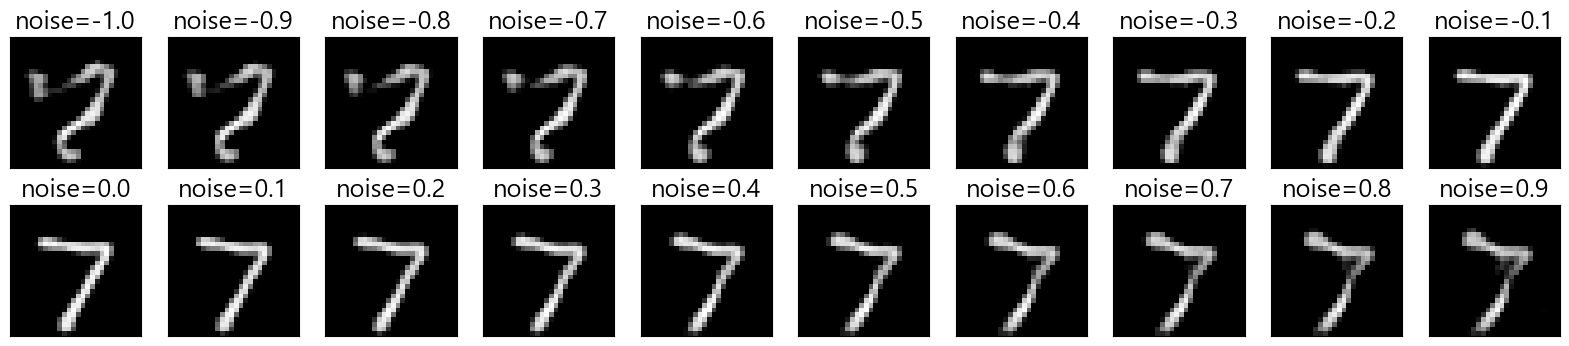

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


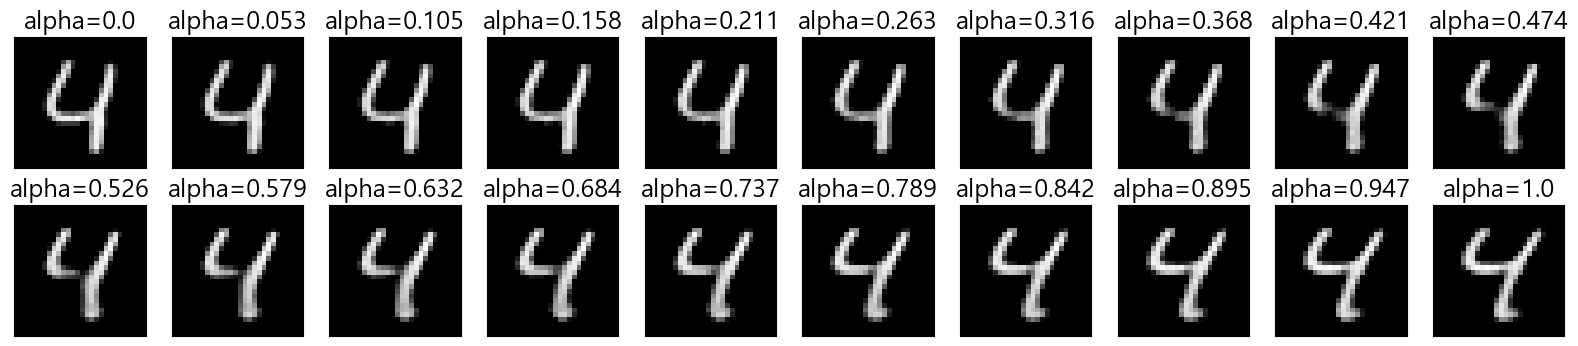

In [8]:
# 생성 실험 1: 첫 번째 샘플의 잠복 공간 표현에 잡음을 섞어 새로운 샘플 생성
x0=x_test[0]
z=model_encoder.predict(x0.reshape(1,28,28,1))
print(np.round(z,3))
zz=np.zeros((20,zdim))
for i in range(20):
    zz[i]=z[0]+(i-10)/10.0
generated_img=model_decoder.predict(zz)

plt.figure(figsize=(20, 4))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(generated_img[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    plt.title('noise='+str((i-10)/10.0))
plt.show()

# 생성 실험 2: 같은 부류의 두 샘플 사이를 보간하여 새로운 샘플 생성
x4_6=np.array((x_test[4],x_test[6]))
z=model_encoder.predict(x4_6)
zz=np.zeros((20,zdim))
for i in range(20):
    alpha=i/(20.0-1.0)
    zz[i]=(1.0-alpha)*z[0]+alpha*z[1]
generated_img=model_decoder.predict(zz)

plt.figure(figsize=(20, 4))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(generated_img[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    plt.title('alpha='+str(round(i/(20.0-1.0),3)))
plt.show()

### 2차원 잠복 공간 관찰

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           6,274 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,946 (386.51 KB)

 Trainable params: 98,946 (386.51 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,017 (398.50 KB)

 Trainable params: 102,017 (398.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 236s 500ms/step - loss: 0.0637 - val_loss: 0.0458
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 219s 288ms/step - loss: 0.0451 - val_loss: 0.0427
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 168s 358ms/step - loss: 0.0427 - val_loss: 0.0415
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 198s 421ms/step - loss: 0.0415 - val_loss: 0.0407
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 179s 380ms/step - loss: 0.0407 - val_loss: 0.0402
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step


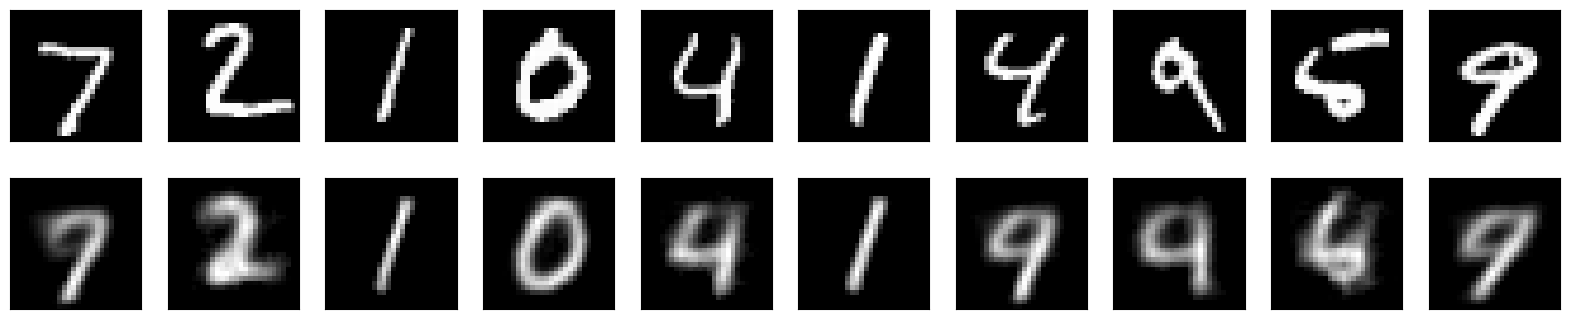

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


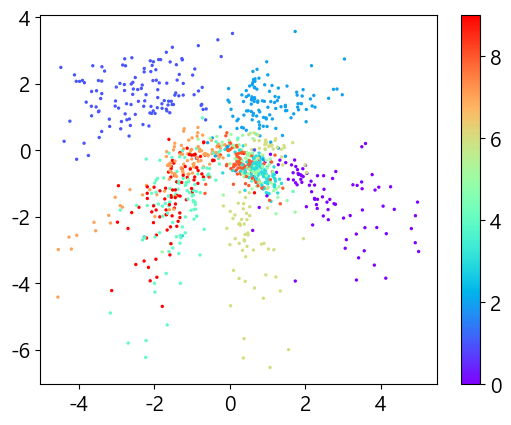

In [9]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# MNIST 데이터를 읽고 신경망에 입력할 준비
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.
x_train=np.reshape(x_train,(len(x_train),28,28,1))
x_test=np.reshape(x_test,(len(x_test),28,28,1))

zdim=2 # 시각화를 위해 2차원으로 설정

# 오토인코더의 인코더 부분 설계
encoder_input=Input(shape=(28,28,1))
x=Conv2D(32,(3,3),activation='relu',padding='same',strides=(1,1))(encoder_input)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x=Flatten()(x)
encoder_output=Dense(zdim)(x)
model_encoder=Model(encoder_input,encoder_output)
model_encoder.summary()

# 오토인코더의 디코더 부분 설계
decoder_input=Input(shape=(zdim,))
x=Dense(3136)(decoder_input)
x=Reshape((7,7,64))(x)
x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(32,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(1,(3,3),activation='relu',padding='same',strides=(1,1))(x)
decoder_output=x
model_decoder=Model(decoder_input,decoder_output)
model_decoder.summary()

# 인코더와 디코더를 결합하여 오토인코더 모델 구축
model_input=encoder_input
model_output=model_decoder(encoder_output)
model=Model(model_input,model_output)

# 오토인코더 학습
model.compile(optimizer='Adam',loss='mse')
model.fit(x_train,x_train,epochs=5,batch_size=128,shuffle=True,validation_data=(x_test,x_test))

decoded_img=model.predict(x_test)

import matplotlib.pyplot as plt

# 테스트 샘플에 대해 복원 품질 평가
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_img[i].reshape(28, 28),cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()

# 테스트 집합의 분포를 2차원 잠복 공간에 시각화
n=1000
xx=x_test[0:n]
z=model_encoder.predict(xx)
sc=plt.scatter(z[:,0],z[:,1],s=2,c=y_test[0:n],cmap='rainbow')
plt.colorbar(sc)

### MNIST를 가지고 GAN을 구현

```
시간이 많이 걸림

c:\DEV\envs\py3_10_tf\lib\site-packages\keras\src\backend\tensorflow\trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


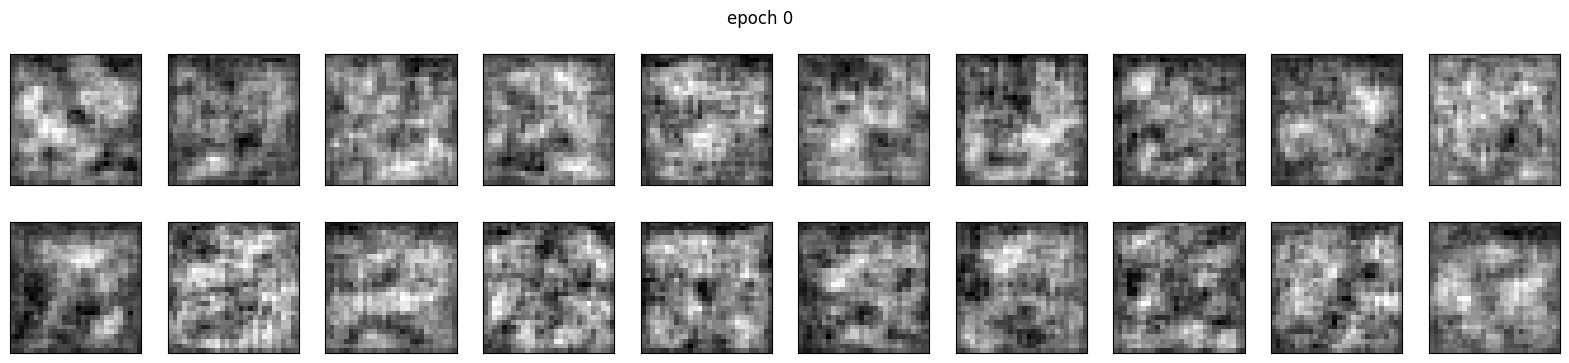

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 489ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 483ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 464ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 466ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 482ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 474ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 

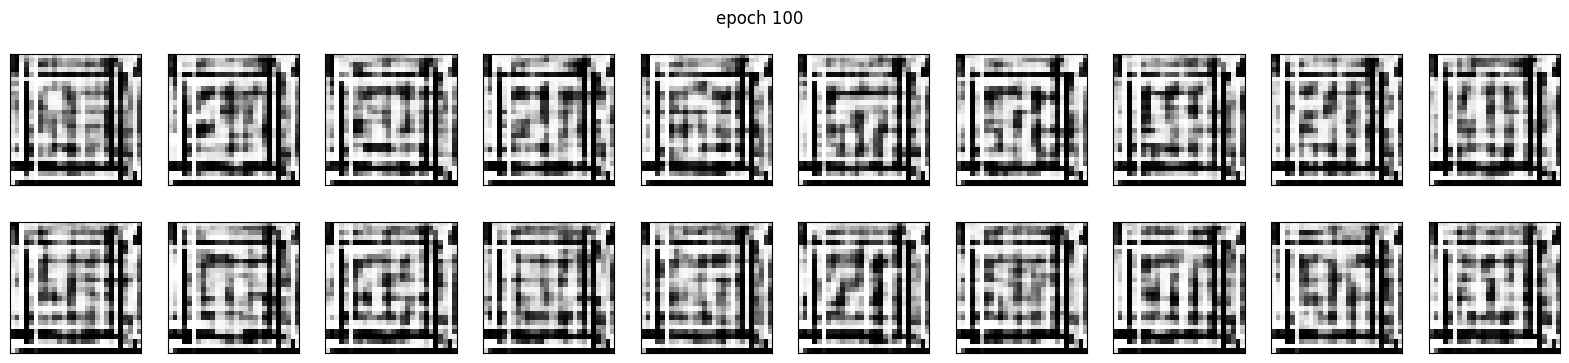

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

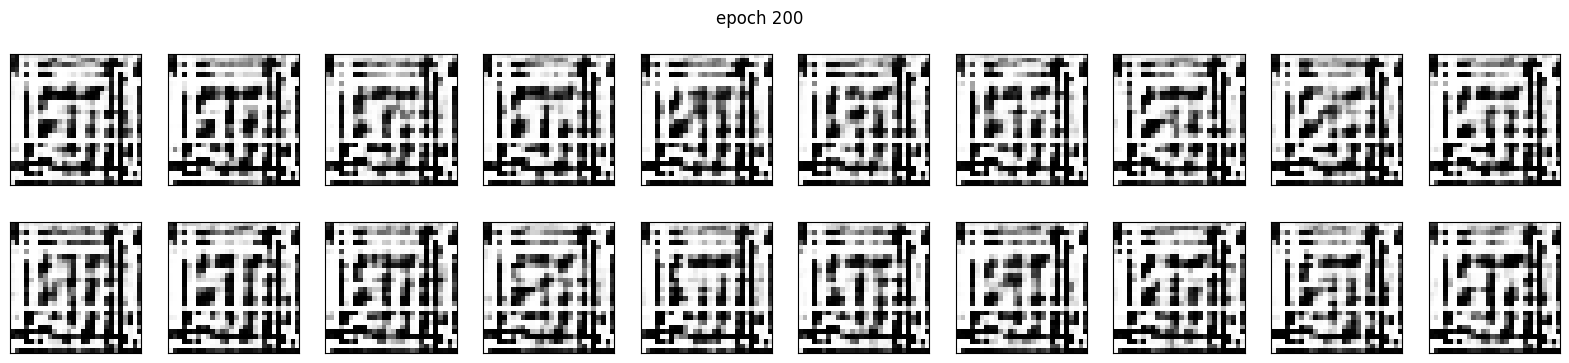

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 999ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 432ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 451ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 432ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 493ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/

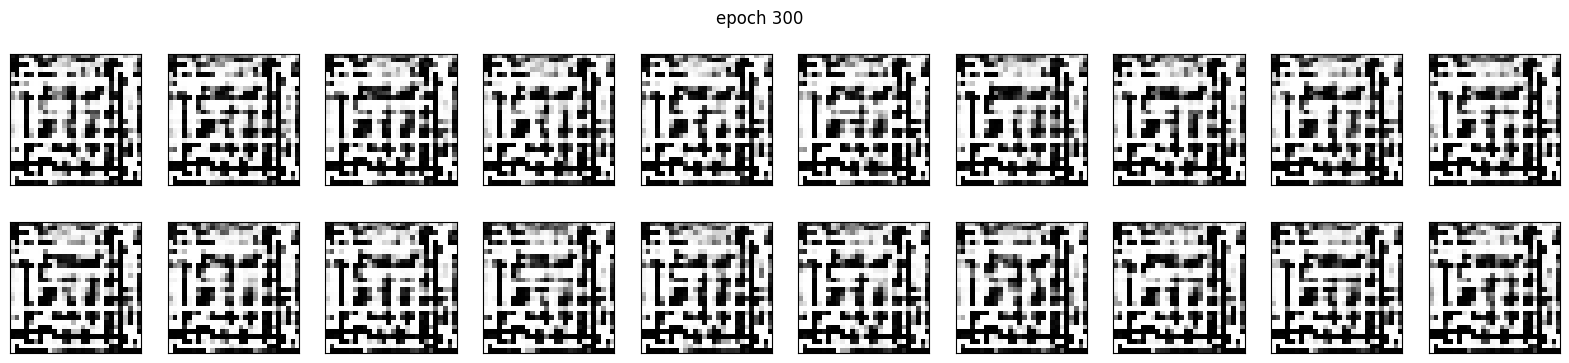

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

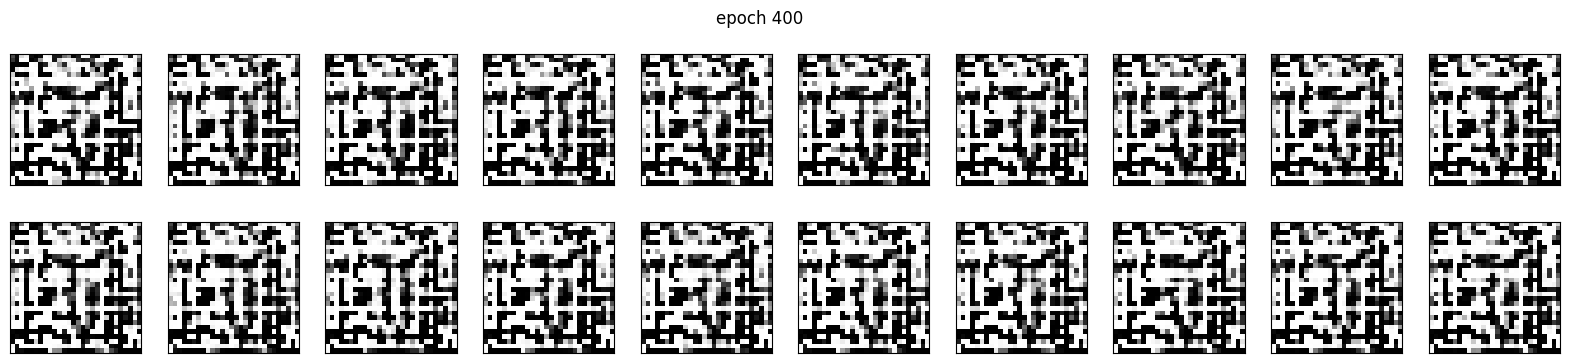

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

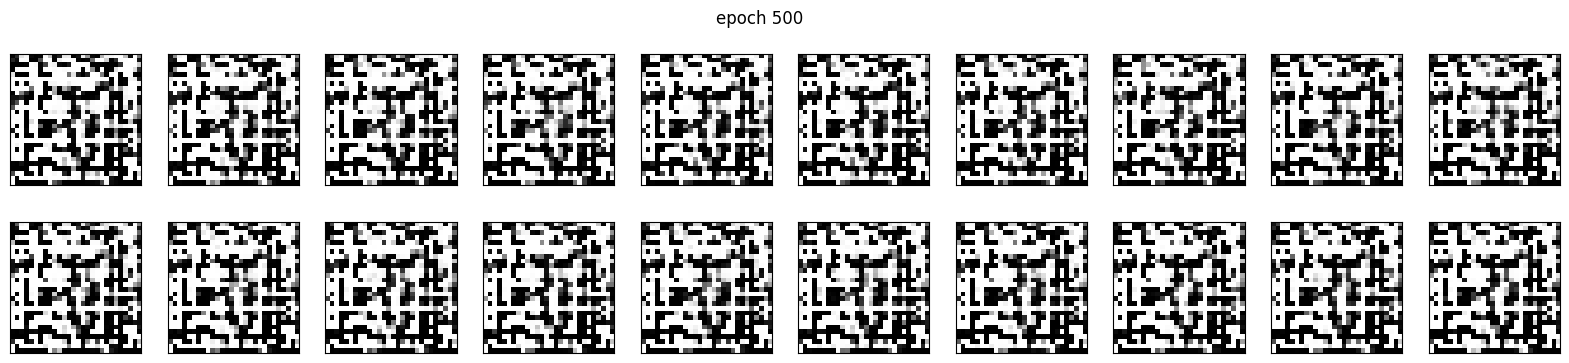

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

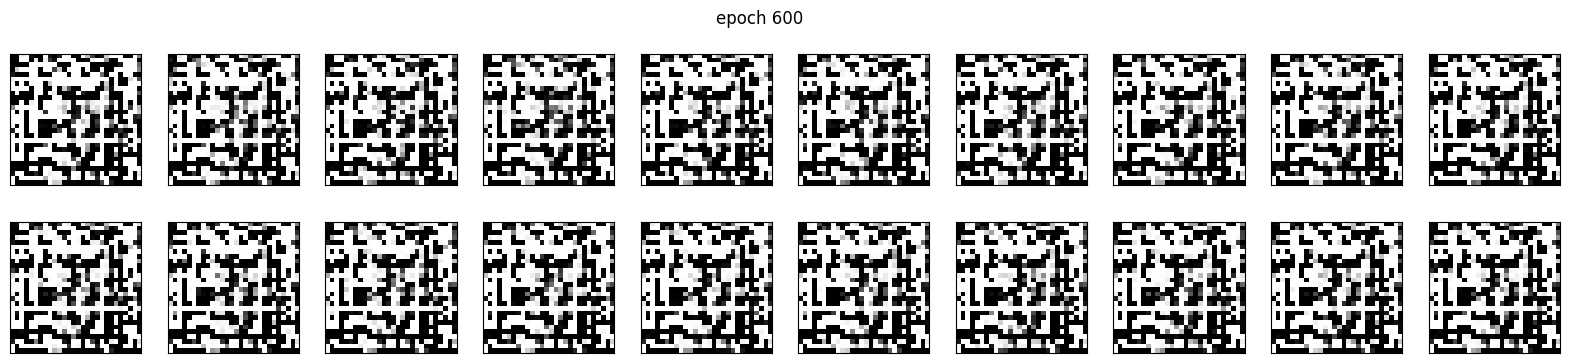

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 499ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

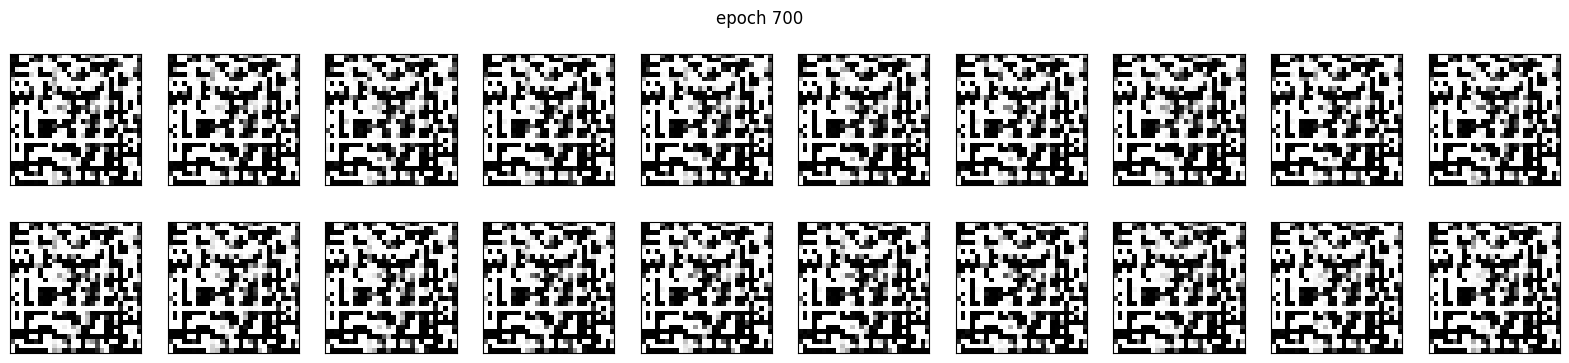

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 506ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 871ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 431ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 973ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 

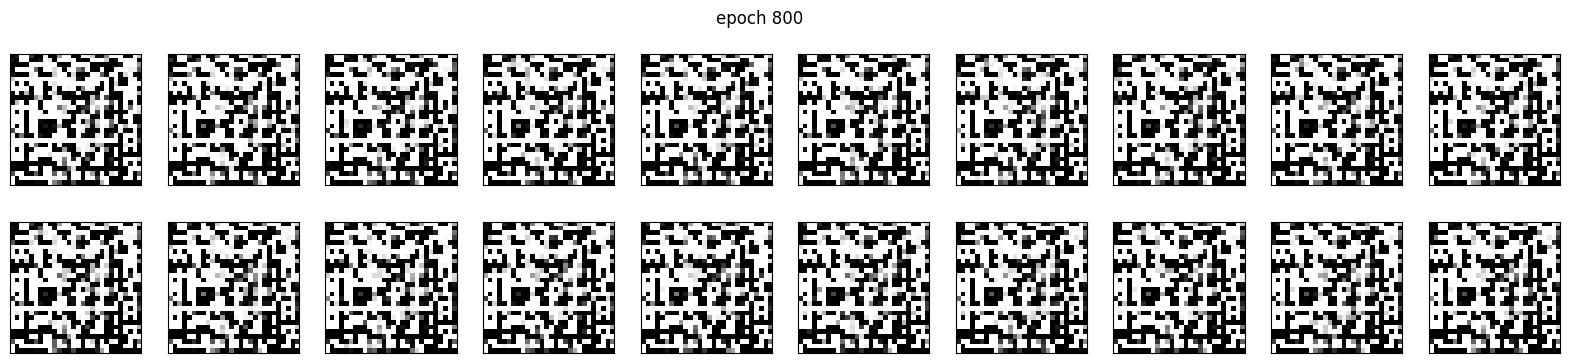

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

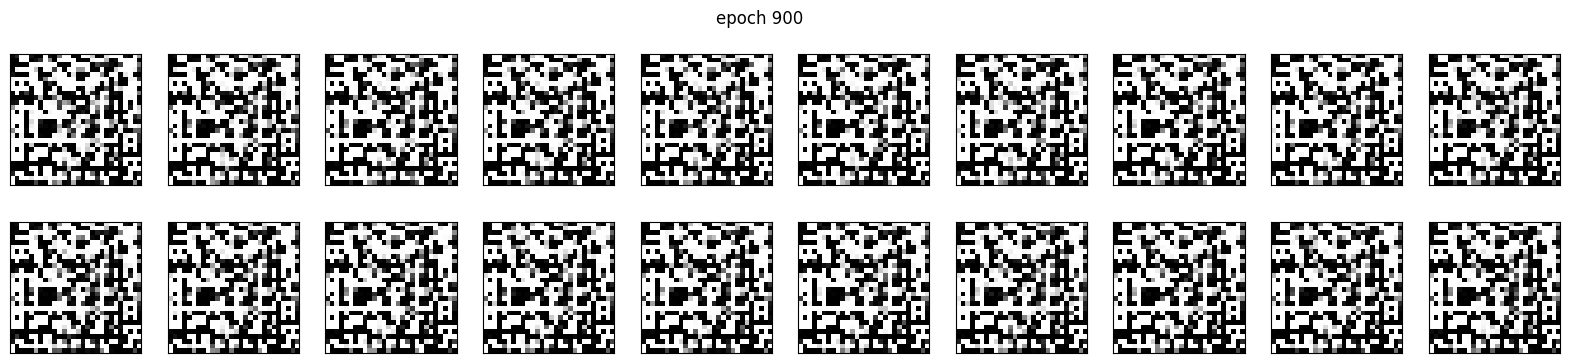

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 445ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 442ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 468ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 402

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Activation,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose,Dropout,BatchNormalization,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import matplotlib.pyplot as plt

(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train = (x_train.astype('float32')/255.0)*2.0-1.0 # [-1,1] 구간
x_test = (x_test.astype('float32')/255.0)*2.0-1.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

batch_siz=64
epochs=5000
dropout_rate=0.4
batch_norm=0.9
zdim=100 # 잠복 공간의 차원

discriminator_input=Input(shape=(28, 28, 1)) # 분별망 D 설계
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(discriminator_input)
x=Dropout(dropout_rate)(x)
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(1,1))(x)
x=Dropout(dropout_rate)(x)
x=Flatten()(x)
discriminator_output=Dense(1,activation='sigmoid')(x)
discriminator=Model(discriminator_input,discriminator_output)

generator_input=Input(shape=(zdim,)) # 생성망 G 설계
x=Dense(3136)(generator_input)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Reshape((7,7,64))(x)
x=UpSampling2D()(x)
x=Conv2D(128,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=UpSampling2D()(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(1,(5,5),activation='tanh',padding='same')(x)
generator_output=x
generator=Model(generator_input,generator_output)

discriminator.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

discriminator.trainable=False
gan_input=Input(shape=(zdim,))
gan_output=discriminator(generator(gan_input))
gan=Model(gan_input,gan_output)
gan.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

def train_discriminator(x_train):
    c=np.random.randint(0,x_train.shape[0],batch_siz)
    real=x_train[c]
    discriminator.train_on_batch(real,np.ones((batch_siz,1)))

    p=np.random.normal(0,1,(batch_siz,zdim))
    fake=generator.predict(p)
    discriminator.train_on_batch(fake,np.zeros((batch_siz,1)))

def train_generator():
    p=np.random.normal(0,1,(batch_siz,zdim))
    gan.train_on_batch(p,np.ones((batch_siz,1)))

for i in range(epochs+1): # 학습을 수행
    train_discriminator(x_train)
    train_generator()
    if(i%100==0): # 학습 도중 100세대마다 중간 상황 출력
        plt.figure(figsize=(20, 4))
        plt.suptitle('epoch '+str(i))
        for k in range(20):
            plt.subplot(2,10,k+1)
            img=generator.predict(np.random.normal(0,1,(1,zdim)))
            plt.imshow(img[0].reshape(28,28),cmap='gray')
            plt.xticks([]); plt.yticks([])
        plt.show()

imgs=generator.predict(np.random.normal(0,1,(50,zdim)))
plt.figure(figsize=(20,10)) # 학습을 마친 후 50개 샘플을 생성하여 출력
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(imgs[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])

### fashion MNIST 데이터로 생성 적대 신경망 학습

c:\DEV\envs\py3_10_tf\lib\site-packages\keras\src\backend\tensorflow\trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


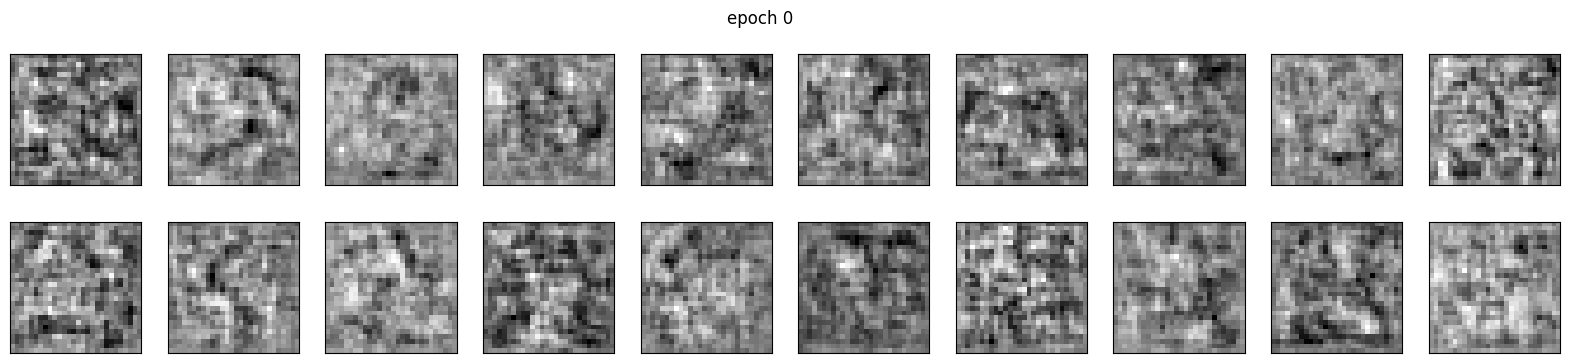

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 441ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 492ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 494ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 469ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 472ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 460ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

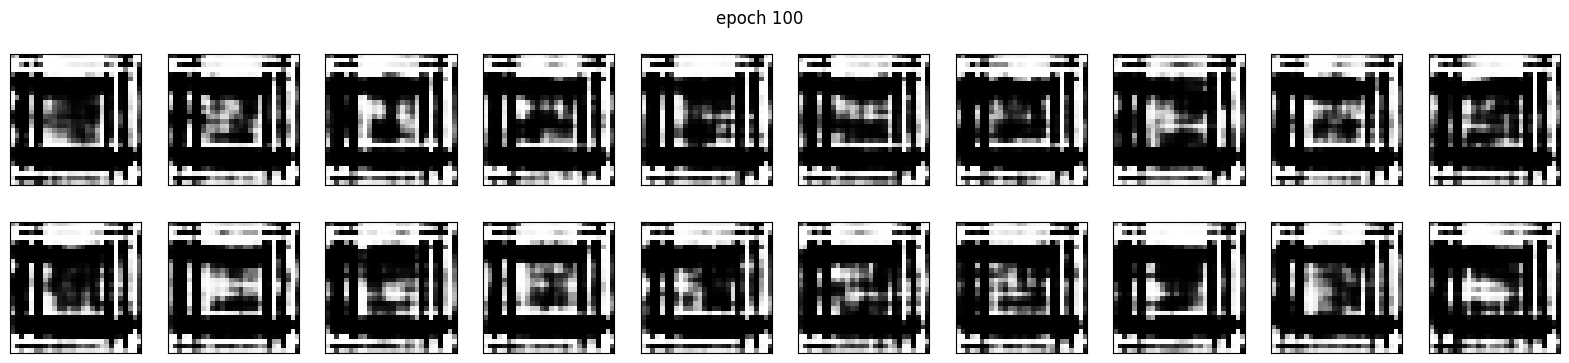

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 417ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

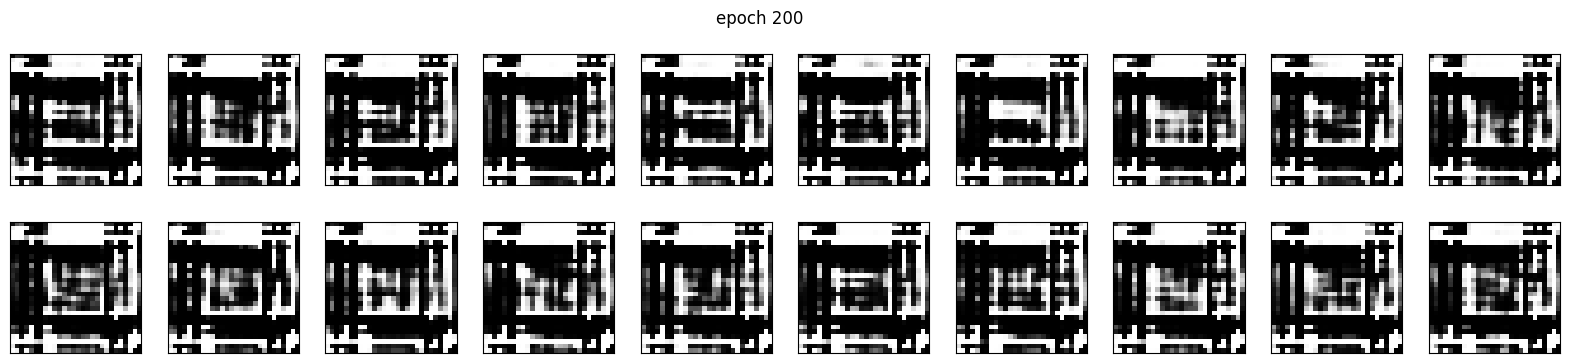

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 813ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 973ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 909ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

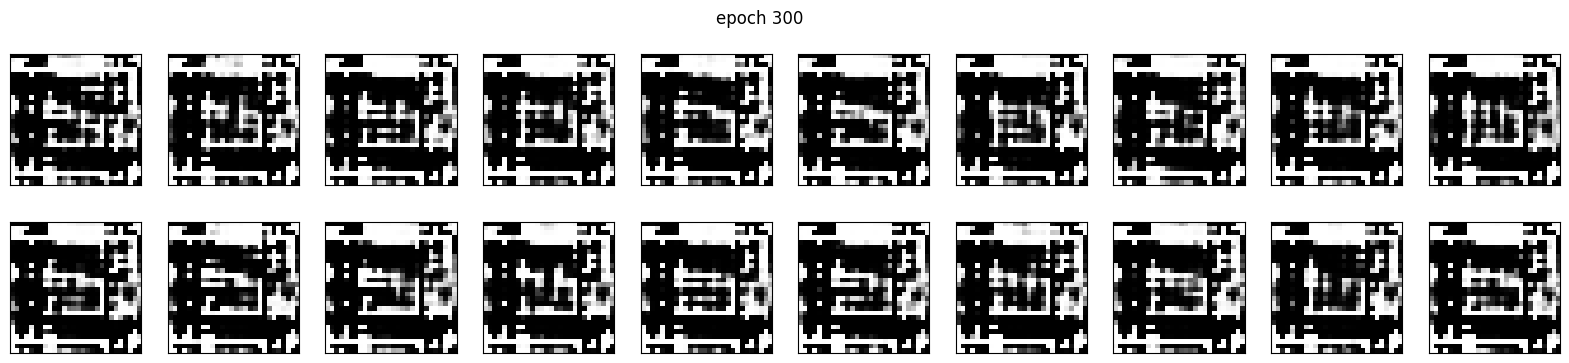

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 878ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 462ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 499ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 811ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 

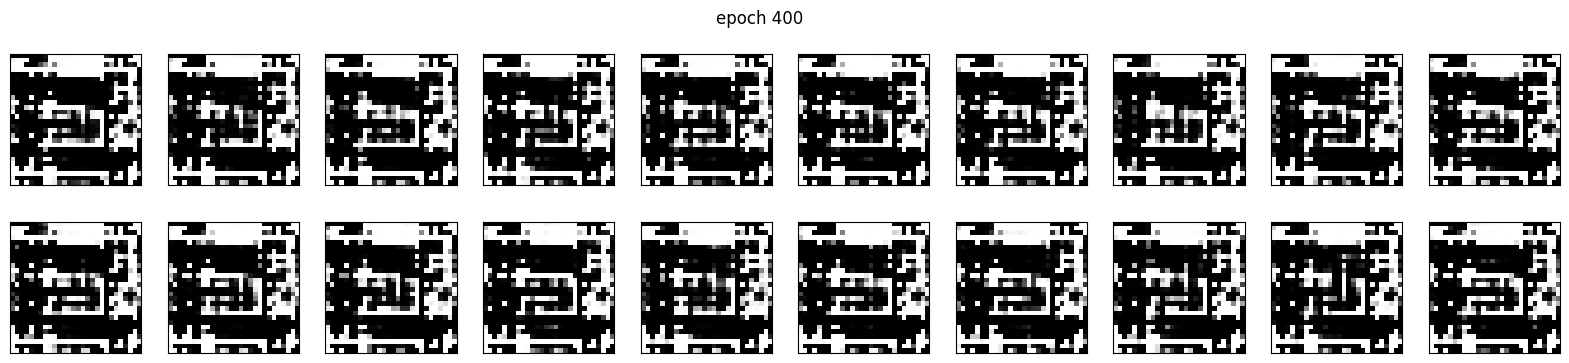

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 751ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 440ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 452ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 489

In [ ]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input,Activation,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose,Dropout,BatchNormalization,UpSampling2D,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import matplotlib.pyplot as plt

(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()
x_train=x_train[np.isin(y_train,[9])] # 9번 부류는 ankle boot
x_train = (x_train.astype('float32')/255.0)*2.0-1.0 # [-1,1] 구간
x_test = (x_test.astype('float32')/255.0)*2.0-1.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

batch_siz=64
epochs=5000
dropout_rate=0.4
batch_norm=0.9
zdim=100 # 잠복 공간의 차원

discriminator_input=Input(shape=(28, 28, 1)) # 분별망 D 설계
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(discriminator_input)
x=Dropout(dropout_rate)(x)
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(1,1))(x)
x=Dropout(dropout_rate)(x)
x=Flatten()(x)
discriminator_output=Dense(1,activation='sigmoid')(x)
discriminator=Model(discriminator_input,discriminator_output)

generator_input=Input(shape=(zdim,)) # 생성망 G 설계
x=Dense(3136)(generator_input)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Reshape((7,7,64))(x)
x=UpSampling2D()(x)
x=Conv2D(128,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=UpSampling2D()(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(1,(5,5),activation='tanh',padding='same')(x)
generator_output=x
generator=Model(generator_input,generator_output)

discriminator.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

discriminator.trainable=False
gan_input=Input(shape=(zdim,))
gan_output=discriminator(generator(gan_input))
gan=Model(gan_input,gan_output)
gan.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

def train_discriminator(x_train):
    c=np.random.randint(0,x_train.shape[0],batch_siz)
    real=x_train[c]
    discriminator.train_on_batch(real,np.ones((batch_siz,1)))

    p=np.random.normal(0,1,(batch_siz,zdim))
    fake=generator.predict(p)
    discriminator.train_on_batch(fake,np.zeros((batch_siz,1)))

def train_generator():
    p=np.random.normal(0,1,(batch_siz,zdim))
    gan.train_on_batch(p,np.ones((batch_siz,1)))

for i in range(epochs+1): # 학습을 수행
    train_discriminator(x_train)
    train_generator()
    if(i%100==0): # 학습 도중 100세대마다 중간 상황 출력
        plt.figure(figsize=(20, 4))
        plt.suptitle('epoch '+str(i))
        for k in range(20):
            plt.subplot(2,10,k+1)
            img=generator.predict(np.random.normal(0,1,(1,zdim)))
            plt.imshow(img[0].reshape(28,28),cmap='gray')
            plt.xticks([]); plt.yticks([])
        plt.show()

imgs=generator.predict(np.random.normal(0,1,(50,zdim)))
plt.figure(figsize=(20,10)) # 학습을 마친 후 50개 샘플을 생성하여 출력
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(imgs[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])

### 생성된 패턴의 품질 평가

In [ ]:
# 훈련 집합 x_train에서 img와 가장 가까운 영상을 찾아주는 함수
def most_similar(img,x_train):
    vmin=1.0e10
    for i in range(len(x_train)):
        dist=np.mean(np.abs(img-x_train[i]))
        if dist<vmin:
            imin,vmin=i,dist
        return x_train[imin]

# 50개의 영상에 대해 가장 가까운 영상을 찾아 보여줌
plt.figure(figsize=(20,10))
for k in range(50):
    plt.subplot(5,10,k+1)
    plt.imshow(most_similar(imgs[k],x_train).reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()

### LSGAN 관련 텐서플로 예제

In [ ]:
# 필요한 라이브러리 불러들임
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
from PIL import Image as Im
import glob
import os

# 그래프 리셋
tf.reset_default_graph()
# 재현성위한 시드 설정
tf.set_random_seed(1)

#--------------------------------------------------
# data 불러오기
#--------------------------------------------------
files=glob.glob('datasets/face20/*.png')
img=[]
for file in files:
    temp=Im.open(file)
    temp=np.array(temp)
    temp=temp[:,:,0:3]/255. # RGBA에서 투명도를 나타내는  a(alpha) 를 삭제하여 RGB로
    img.append(temp)

# 리스트를 array로
x=np.asarray(img)
n_cell=np.prod(x.shape[1:4]) # 45*40*3=5400
# 이미지를 벡터로 =[20,5400]
X_vec=np.reshape(x,[len(img),n_cell])

# 관측치 수
sample_size=X_vec.shape[0] #=20
# 입력 변수 수
input_dim = X_vec.shape[1] #=5400


#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 입력 잡음신호의 차원: 100
# 생성자의 두 은닉층 크기: 128
# 판별자의 두 은닉층 크기: 128
# 미니배치 크기: 20
# 반복 수: 500
# 학습률 : 0.001
learning_rate = 0.001
batch_size = 20
z_size = 100
nepochs = 500
g_hidden_size = 128 # 생성자 은닉층 크기
d_hidden_size = 128 # 판별자  은닉층 크기

# 드롭아웃에서 보존할 노드의 비율
keep_prob = tf.placeholder(tf.float32,name='keep_prob')

# 진짜데이터 placeholder
X = tf.placeholder(tf.float32, shape=[None, input_dim], name='X')
# 잡음 placeholder
Z = tf.placeholder(tf.float32, shape=[None, z_size], name='Z')

# 생성망의 가중치와 편의 정의(# 사비에르 초기치 사용)
G_W1 = tf.get_variable('G_W1',shape=[z_size,g_hidden_size],initializer = tf.truncated_normal_initializer(stddev=0.1))
G_b1 = tf.Variable(tf.zeros(shape=[g_hidden_size]), name='G_b1')
G_W2 = tf.get_variable('G_W2',shape=[g_hidden_size,input_dim],initializer = tf.truncated_normal_initializer(stddev=0.1))
G_b2 = tf.Variable(tf.zeros(shape=[input_dim]), name='G_b2')
theta_G = [G_W1, G_W2, G_b1, G_b2]

# 판별망의 가중치와 편의 정의(# 사비에르 초기치 사용)
D_W1 = tf.get_variable('D_W1',shape=[input_dim,d_hidden_size],initializer = tf.truncated_normal_initializer(stddev=0.1))
D_b1 = tf.Variable(tf.random_normal([d_hidden_size]), name='D_b1')
D_W2 = tf.get_variable('D_W2',shape=[d_hidden_size,1],initializer = tf.truncated_normal_initializer(stddev=0.1))
D_b2 = tf.Variable(tf.random_normal([1]), name='D_b2')
theta_D = [D_W1, D_W2, D_b1, D_b2]

#------------------------------------------------
# 생성자 정의: 입력된 진짜 데이터와 유사한 가짜 데이터 생성
#------------------------------------------------
def generator(z):
        h1 = tf.matmul(z, G_W1) + G_b1
        h1 = tf.maximum(0., h1)  #ReLU
        h2 = tf.matmul(h1, G_W2) + G_b2
        out = tf.nn.tanh(h2)
        return out

#------------------------------------------------
# 판별자 정의: 입력된 진짜 데이터와 가짜 데이터를 정확하게 분류
#------------------------------------------------
def discriminator(x):
        h1=tf.matmul(x, D_W1) + D_b1
        h1 = tf.maximum(0., h1)  #ReLU
        h1=tf.nn.dropout(h1, keep_prob)
        h2 = tf.matmul(h1, D_W2) + D_b2
        h2=tf.nn.dropout(h2, keep_prob)
        prob = tf.nn.sigmoid(h2)
        return prob, h2

G = generator(Z) # 가짜데이터
# 진짜 데이터의 판별망 결과
D_real, D_logit_real = discriminator(X)
# 가짜 데이터의 판별망 결과
D_fake, D_logit_fake = discriminator(G)

# 비용함수
# 판별자는 진짜데이터는 1, 가짜데이터는 0이 되게
D_loss = 0.5 * (tf.reduce_mean((D_real - 1)**2) + 0.5*tf.reduce_mean(D_fake**2))
# 생성자는 가짜데이터의 판별망 결과가 1이 되게 만들어야 한다
G_loss = 0.5 * tf.reduce_mean((D_fake - 1)**2)

# 판별망을 훈련할 때는  theta_D 만 업데이트 된다.
D_solver = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=theta_D)
# 생성망 훈련할 때는  theta_G 만 업데이트 된다.
G_solver = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=theta_G)

#------------------------------------------------
# 텐서플로 그래프 생성 및 학습
#------------------------------------------------
sess=tf.Session();
sess.run(tf.global_variables_initializer())
losses = []

for epoch in range(nepochs):
    n_batch=int(sample_size/batch_size)

    for ii in range(n_batch):
        if ii!=n_batch:
              batch_images=X_vec[ii*batch_size:(ii+1)*batch_size]
        else:
              batch_images=X_vec[(ii+1)*batch_size:]
        batch_images = batch_images*2 - 1
        batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        D_loss_curr,_ =sess.run([D_loss,D_solver], feed_dict={X: batch_images, Z: batch_z,keep_prob:0.8})
        G_loss_curr,_=sess.run([G_loss,G_solver], feed_dict={X: batch_images, Z: batch_z,keep_prob:0.8})
        losss=D_loss_curr+G_loss_curr

    print('Epoch: {0}, Discriminator Loss: {1:7.4f}, Generator Loss: {2:7.4f}'  .format(epoch+1,D_loss_curr, G_loss_curr))
    losses.append((D_loss_curr, G_loss_curr))
    # 100 에폭 마다 가짜데이터 그림
    if (epoch+1)%100==0:
        tf.set_random_seed(0)
        sample_z = np.random.uniform(-1, 1, size=(20,z_size))
        gen_samples = sess.run(G,feed_dict={Z: sample_z})
        f,axes =plt.subplots(figsize=(7,7), nrows=5, ncols=4, sharey=True, sharex=True)
        f.suptitle(epoch+1)
        for ii in range(20):
             plt.subplot(5,4,ii+1)
             gs=gen_samples[ii].reshape(45,40,3);
             gs=(gs-np.min(gs))/(np.max(gs)-np.min(gs))
             plt.imshow(gs)

# 판별자, 생성자의 비용함수 그림
fig, ax = plt.subplots(figsize=(7,7))
losses = np.array(losses)
plt.plot(losses.T[0], 'r-',label='Discriminator')
plt.plot(losses.T[1], 'b-',label='Generator')

plt.title("Training Losses")
plt.legend()


#진짜 이미지 그림
f,axes =plt.subplots(figsize=(7,7), nrows=5, ncols=4, sharey=True, sharex=True)
for ii in range(20):
    plt.subplot(5,4,ii+1)
    gs=X_vec[ii].reshape(45,40,3);  gs=(gs-np.min(gs))/(np.max(gs)-np.min(gs))
    plt.imshow(gs)

### DCGAN

In [ ]:
# 필요한 라이브러리 불러들임
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
from PIL import Image as Im
import glob
import os

# 그래프 리셋
tf.reset_default_graph()
# 재현성위한 시드 지정
tf.set_random_seed(1)

#--------------------------------------------------
# data 불러오기
#--------------------------------------------------
files=glob.glob('datasets/face20/*.png')
img=[]
for file in files:
    temp=Im.open(file)
     #계산 시간 절약위해 흑백으로
    temp=temp.convert('L')
    temp=np.array(temp)
    img.append(temp)

# 리스트를 array로
x=np.asarray(img)
n_cell=np.prod(x.shape[1:3]) # 45*40=1800
# 이미지를 벡터로 =[20,1800]
Ximg=np.reshape(x,[len(img),n_cell]) #=[20,1800]
Ximg=Ximg.reshape(20,45,40,1) # = [batch,height,width,channels]
# 관측치 수
sample_size=Ximg.shape[0] #=20
# 입력 변수 수
input_dim =Ximg.shape[1] #=1800


#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 입력 잡음신호의 차원: 50
# 미니배치 크기: 10
# 반복 수: 200
# 학습률 : 0.01
# Adam optimize 매개변수: 0.9, 0.999
learning_rate = 0.01 #학습률
beta1=0.9 #Adam optimizer 매개변수
beta2=0.999 #Adam optimizer 매개변수
batch_size = 10 # 배치크기
z_size = 50 #잡음 크기
nepochs = 200 # 반복 수
alpha=0.1# for leaky Relu, alpha=0 --> ReLu

# 드롭아웃에서 보존할 노드의 비율
keep_prob = tf.placeholder(tf.float32,name='keep_prob')



#------------------------------------------------
# 생성자 정의: 입력된 진짜 이미지와 유사한 가짜 이미지 생성
#------------------------------------------------
# 전치합성곱 연산
# 패딩 없이(valid) 혹은 같은 크기 출력되는 패딩(same)
# 배치정규화, leaky-ReLu, tanh 활성함수
def generator(z, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
       G_conv1 = tf.layers.conv2d_transpose(z, 360, [2, 2], strides=(2, 2), padding='valid')
       G_conv1=tf.layers.batch_normalization(G_conv1, training=True)
       G_conv1 = tf.maximum(alpha*G_conv1, G_conv1)
       G_conv2 = tf.layers.conv2d_transpose(G_conv1, 180, [3, 3], strides=(2,2), padding='valid')
       G_conv2=tf.layers.batch_normalization(G_conv2, training=True)
       G_conv2 = tf.maximum(alpha*G_conv2, G_conv2)
       G_conv3 = tf.layers.conv2d_transpose(G_conv2, 90, [3, 4], strides=(3, 4), padding='same')
       G_conv3=tf.layers.batch_normalization(G_conv3, training=True)
       G_conv3 = tf.maximum(alpha*G_conv3, G_conv3)
       G_conv4 = tf.layers.conv2d_transpose(G_conv3, 1, [3, 3], strides=(3, 2), padding='same')
       G_out = tf.nn.tanh(G_conv4)
       return G_out

#------------------------------------------------
# 판별자 정의: 입력된 진짜 데이터와 가짜 데이터를 정확하게 분류
#------------------------------------------------
# 합성곱 연산
# 패딩 없이(valid) 혹은 입력과 같은 크기가 출력되도록 하는 패딩(same)
# 배치정규화 사용, leaky-ReLu 활성함수
def discriminator(x, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        D_conv1 = tf.layers.conv2d(x, 90, [3, 3], strides=(3, 2), padding='same')
        D_conv1=tf.layers.batch_normalization(D_conv1, training=True)
        D_conv1 = tf.maximum(alpha*D_conv1, D_conv1)
        D_conv2 = tf.layers.conv2d(D_conv1, 180, [3, 4], strides=(3, 4), padding='same')
        D_conv2=tf.layers.batch_normalization(D_conv2, training=True)
        D_conv2 = tf.maximum(alpha*D_conv2, D_conv2)
        D_conv3 = tf.layers.conv2d(D_conv2, 360, [3, 3], strides=(2, 2), padding='valid')
        D_conv3=tf.layers.batch_normalization(D_conv3, training=True)
        D_conv3 = tf.maximum(alpha*D_conv3, D_conv3)
        D_conv4 = tf.layers.conv2d(D_conv3, 1, [2, 2], strides=(2, 2), padding='valid')
        D_out = tf.nn.sigmoid(D_conv4)
        return D_out, D_conv4

# 진짜데이터 placeholder
X = tf.placeholder(tf.float32, shape=[None,45,40, 1])
# 잡음 placeholder
Z = tf.placeholder(tf.float32, shape=[None, 1,1,z_size])

# 가짜데이터
G = generator(Z)
# 진짜데이터의 판별망 결과
D_real, D_logit_real = discriminator(X)
# 가짜데이터의 판별망 결과
D_fake, D_logit_fake = discriminator(G, reuse=True)

# 비용함수
# 진짜데이터는 1에 가깝게
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
# 가짜데이터는 0에 가깝게
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
# 생성자는 가짜데이터의 판별망 결과가 1이 되게 만들어야 한다.
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))


# 각 신경망에 업데이트되는 변수
T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]

#Optimizer
D_solver = tf.train.AdamOptimizer(learning_rate,beta1,beta2).minimize(D_loss, var_list=D_vars)
G_solver = tf.train.AdamOptimizer(learning_rate,beta1,beta2).minimize(G_loss, var_list=G_vars)

#------------------------------------------------
# 텐서플로 그래프 생성 및 학습
#------------------------------------------------
sess=tf.Session();
sess.run(tf.global_variables_initializer())
losses = []
for epoch in range(nepochs):
    n_batch=int(sample_size/batch_size)
    avg_loss=0
    for ii in range(n_batch):
        if ii!=n_batch:
              batch_x=Ximg[ii*batch_size:(ii+1)*batch_size]
        else:
              batch_x=Ximg[(ii+1)*batch_size:]
        #batch_images=tf.reshape(batch_images,[-1,45,40,1])
        #tf.set_random_seed(ii)
        batch_x=2*batch_x-1
        batch_z = np.random.uniform(-1, 1, size=(batch_size,1,1, z_size))
        D_loss_curr,_ =sess.run([D_loss,D_solver], feed_dict={X: batch_x, Z: batch_z,keep_prob:0.9})
        G_loss_curr,_=sess.run([G_loss,G_solver], feed_dict={X: batch_x, Z: batch_z,keep_prob:0.9})
        losss=D_loss_curr+G_loss_curr

    print('Epoch: {0}, Discriminator Loss: {1:7.4f}, Generator Loss: {2:7.4f}'  .format(epoch+1,D_loss_curr, G_loss_curr))
    losses.append((D_loss_curr, G_loss_curr,avg_loss))

    # 10 에폭마다 가짜 이미지 그림
    if (epoch+1)%10==0:
        tf.set_random_seed(0)
        sample_z = np.random.normal(0, 1, size=(16,1,1,z_size))
        gen_samples = sess.run(G,feed_dict={Z: sample_z})
        f,axes =plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
        f.suptitle(epoch+1)
        for ii in range(16):
            plt.subplot(4,4,ii+1)
            plt.imshow(gen_samples[ii].reshape((45,40)), cmap='Greys_r')

# 판별자, 생성자의 비용함수 그림
fig, ax = plt.subplots(figsize=(7,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

#진짜 이미지 그림
f,axes =plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(Ximg[ii].reshape(45,40),cmap='Greys_r')

### 와서스타인 경쟁적 생성망

In [ ]:
# 필요한 라이브러리 불러들임
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
from PIL import Image as Im
import glob
import os

# 그래프 리셋
tf.reset_default_graph()
# 재현성을 위해 시드 지정
tf.set_random_seed(1)

#--------------------------------------------------
# data 불러오기
#--------------------------------------------------
files=glob.glob('datasets/face20/*.png')
img=[]
for file in files:
    temp=Im.open(file);
    temp=temp.convert('L') # 계산 시간 절약 위해 흑백으로
    temp=np.array(temp)
    img.append(temp)


# 리스트를 array로
x=np.asarray(img)/255.
n_cell=np.prod(x.shape[1:3]) # 45*40=1800
# 이미지를 벡터로 =[20,1800]
Ximg=np.reshape(x,[len(img),n_cell]) #=[20,1800]

# 관측치 수 (=20)
sample_size=Ximg.shape[0] #=20
# 입력 변수 수 (=1800)
input_dim = Ximg.shape[1] #=1800


#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 입력 잡음신호의 차원: 50
# 생성자의 두 은닉층 크기: 128
# 비판자의 두 은닉층 크기: 128
# 미니배치 크기: 10
# 반복 수: 200
# 학습률 : 0.01
# 클립핑 값 : 0.01
learning_rate = 0.001 #학습률
batch_size = 5 # 배치크기
z_size = 50 #잡음 크기
nepochs = 200 # 반복 수
g_hidden_size = 128 # 생성자 은닉층 크기
d_hidden_size = 128 # 판별자  은닉층 크기
clip=0.01
alpha=0.1# for leaky Relu, alpha=0 --> ReLu

# 진짜데이터 placeholder
X = tf.placeholder(tf.float32, shape=[None, input_dim], name='X')
# 집음 placeholder
Z = tf.placeholder(tf.float32, shape=[None, z_size], name='Z')

# 비판자의 가중치와 편의 정의(# 사비에르 초기치 사용)
D_W1 = tf.get_variable('D_W1',shape=[input_dim,d_hidden_size],initializer = tf.truncated_normal_initializer(stddev=0.1))
D_b1 = tf.Variable(tf.random_normal([d_hidden_size]), name='D_b1')
D_W2 = tf.get_variable('D_W2',shape=[d_hidden_size,1],initializer = tf.truncated_normal_initializer(stddev=0.1))
D_b2 = tf.Variable(tf.random_normal([1]), name='D_b2')
theta_D = [D_W1, D_W2, D_b1, D_b2]


# 생성망의 가중치와 편의 정의(# 사비에르 초기치 사용)
G_W1 = tf.get_variable('G_W1',shape=[z_size,g_hidden_size],initializer = tf.truncated_normal_initializer(stddev=0.1))
G_b1 = tf.Variable(tf.zeros(shape=[g_hidden_size]), name='G_b1')
G_W2 = tf.get_variable('G_W2',shape=[g_hidden_size,input_dim],initializer = tf.truncated_normal_initializer(stddev=0.1))
G_b2 = tf.Variable(tf.zeros(shape=[input_dim]), name='G_b2')
theta_G = [G_W1, G_W2, G_b1, G_b2]

#------------------------------------------------
# 생성자 정의: 입력된 진짜 이미지와 유사한 가짜 이미지 생성
#------------------------------------------------
def generator(z):
        h1=tf.matmul(z, G_W1) + G_b1
        h1 = tf.maximum(alpha*h1, h1)
        h2 = tf.matmul(h1, G_W2) + G_b2
        out = tf.nn.sigmoid(h2)
        return out


#------------------------------------------------
# 비판자 정의: 입력된 진짜 데이터와 가짜 데이터를 정확하게 분류
#------------------------------------------------
def critic(x):
        h1=tf.matmul(x, D_W1) + D_b1
        h1 = tf.maximum(alpha*h1, h1)
        h2 = tf.matmul(h1, D_W2) + D_b2
        #prob = tf.nn.sigmoid(h2)
        return h2

# 가짜데이터
G = generator(Z)

# 진짜 데이터의 비판자 결과
D_logit_real = critic(X)
D_logit_fake = critic(G)

#비용함수
D_loss = tf.reduce_mean(D_logit_real) - tf.reduce_mean(D_logit_fake)
G_loss = -tf.reduce_mean(D_logit_fake)

# Optimizer
D_solver = tf.train.RMSPropOptimizer(learning_rate).minimize(-D_loss, var_list=theta_D)
G_solver = tf.train.RMSPropOptimizer(learning_rate).minimize(G_loss, var_list=theta_G)

# 클립핑을 통해 1-Lipshitz 조건 충족
clip_D = [p.assign(tf.clip_by_value(p, -clip, clip)) for p in theta_D]

#------------------------------------------------
# 텐서플로 그래프 생성 및 학습
#------------------------------------------------
sess=tf.Session();
sess.run(tf.global_variables_initializer())
samples = []
losses = []

for epoch in range(nepochs):
    n_batch=int(sample_size/batch_size)
    avg_loss=0
    for ii in range(n_batch):
        if ii!=n_batch:
              batch_images=Ximg[ii*batch_size:(ii+1)*batch_size]
        else:
              batch_images=Ximg[(ii+1)*batch_size:]
        batch_images = batch_images*2 - 1
        batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        D_loss_curr,_ ,clipD=sess.run([D_loss,D_solver,clip_D], feed_dict={X: batch_images, Z: batch_z})
        G_loss_curr,_=sess.run([G_loss,G_solver], feed_dict={X: batch_images, Z: batch_z})
        losss=D_loss_curr+G_loss_curr
        avg_loss+=losss/n_batch
   # print('Epoch: {0}, Discriminator Loss: {1:7.4f}, Generator Loss: {2:7.4f}'  .format(epoch+1,D_loss_curr, G_loss_curr))
    losses.append((D_loss_curr, G_loss_curr,avg_loss))
    # 20 에폭마다 가짜 이미지 그림
    if (epoch+1)%20==0:
        tf.set_random_seed(0)
        sample_z = np.random.uniform(-1, 1, size=(16,z_size))
        gen_samples = sess.run(G,feed_dict={Z: sample_z})
        f,axes =plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
        f.suptitle(epoch+1)
        for ii in range(16):
            plt.subplot(4,4,ii+1)
            plt.imshow(gen_samples[ii].reshape((45,40)), cmap='Greys_r')

# 비판자, 생성자의 비용함수 그림
fig, ax = plt.subplots(figsize=(7,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Critic')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()


# 진짜데이터 그림
f,axes =plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(Ximg[ii].reshape(45,40),cmap='Greys_r')

### 조건 경쟁적 생성망(CGAN)

In [ ]:
# 필요한 라이브러리 불러들임
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
import os

# 그래프 리셋
tf.reset_default_graph()
# 재현성을 위해 시드 지정
tf.set_random_seed(2)

#--------------------------------------------------
# data 불러오기
#--------------------------------------------------
#os.chdir('C:/Users/admin/.../')

# data load
f1 = open (r'./mnist_generate/traindata.txt','r')
X0 =[]
X0 =[line.split() for line in f1]
f1.close()
Xvec=np.array(X0, dtype=np.float32)

f1 = open (r'./mnist_generate/trainlabels.txt','r')
y =[]
y =[line.split()for line in f1]
f1.close()
y=np.array(y, np.int64)

sample_size=Xvec.shape[0]
Y_onehot=np.zeros((sample_size,10))

# 원-핫 코딩
for ii in range(sample_size):
    Y_onehot[ii, y[ii]]=1

# 입력 변수 수 (=784)
input_dim = Xvec.shape[1] #=784
# 라벨 정보 변수 수 (=10)
y_dim=Y_onehot.shape[1] #=10

#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 입력 잡음신호의 차원: 100
# 미니배치 크기: 100
# 반복 수: 200
# 학습률 : 0.001
# 생성자의 두 은닉층 크기: 128
# 판별자의 두 은닉층 크기: 128

learning_rate = 0.001# 학습률
batch_size = 100 #배치크기
z_size = 100 #잡음크기
nepochs = 200 # epochs
g_hidden_size = 128
d_hidden_size = 128
alpha=0.1 # Leaky ReLu, alpha=0 --> ReLu

# 드롭아웃에서 보존할 노드의 비율
keep_prob = tf.placeholder(tf.float32,name='keep_prob') # dropout

# 라벨 정보 placeholder
Y = tf.placeholder(tf.float32, shape=[None, y_dim], name='Y')
# 진짜데이터 placeholder
X = tf.placeholder(tf.float32, shape=[None, input_dim], name='X')
# 잡음 placeholder
Z = tf.placeholder(tf.float32, shape=[None, z_size], name='Z')

#판별자에 사용되는 가중치와 편의
D_W1 = tf.get_variable('D_W1',shape=[input_dim+y_dim,d_hidden_size],initializer = tf.truncated_normal_initializer(stddev=0.1))
D_b1 = tf.Variable(tf.random_normal([d_hidden_size]), name='D_b1')
D_W2 = tf.get_variable('D_W2',shape=[d_hidden_size,1],initializer = tf.truncated_normal_initializer(stddev=0.1))
D_b2 = tf.Variable(tf.random_normal([1]), name='D_b2')
theta_D = [D_W1, D_W2, D_b1, D_b2]


# 생성에 사용되는 가중치와 편의
G_W1 = tf.get_variable('G_W1',shape=[z_size+y_dim,g_hidden_size],initializer = tf.truncated_normal_initializer(stddev=0.1))
G_b1 = tf.Variable(tf.zeros(shape=[g_hidden_size]), name='G_b1')
G_W2 = tf.get_variable('G_W2',shape=[g_hidden_size,input_dim],initializer = tf.truncated_normal_initializer(stddev=0.1))
G_b2 = tf.Variable(tf.zeros(shape=[input_dim]), name='G_b2')
theta_G = [G_W1, G_W2, G_b1, G_b2]

#------------------------------------------------
# 생성자 정의: 입력된 진짜 이미지와 유사한 가짜 이미지 생성
#------------------------------------------------
def generator(z,y):
    with tf.variable_scope('generator'):
        zy=tf.concat([z,y],axis=1)
        h1=tf.matmul(zy, G_W1) + G_b1
        h1 = tf.maximum(alpha*h1, h1)
        h2 = tf.matmul(h1, G_W2) + G_b2
        out = tf.nn.tanh(h2)
        return out

#------------------------------------------------
# 판별자 정의: 입력된 진짜 데이터와 가짜 데이터를 정확하게 분류
#------------------------------------------------
def discriminator(x,y):
    with tf.variable_scope('discriminator'):
        xy=tf.concat([x,y],axis=1)
        h1=tf.matmul(xy, D_W1) + D_b1
        h1 = tf.maximum(alpha*h1, h1)
        h1=tf.nn.dropout(h1, keep_prob)
        h2 = tf.matmul(h1, D_W2) + D_b2
        h2=tf.nn.dropout(h2, keep_prob)
        prob = tf.nn.sigmoid(h2)
        return prob, h2


# 가짜데이터
G = generator(Z,Y)
# D(.|Y). 진짜데이터와 가짜데이터의 조건부 판별망 결과
D_real, D_logit_real = discriminator(X,Y)
D_fake, D_logit_fake = discriminator(G,Y)

#비용함수
# 판별자는 진짜데이터는 1, 가짜데이터는 0이 되게
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake

# 생성자는 가짜데이터의 판별망 결과가 1이 되게 만들어야 한다
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

#Optimizer
# 판별망을 훈련할 때는  theta_D 만 업데이트 된다.
D_solver = tf.train.AdamOptimizer(learning_rate,beta1=0.1).minimize(D_loss, var_list=theta_D)
# 생성망 훈련할 때는  theta_G 만 업데이트 된다.
G_solver = tf.train.AdamOptimizer(learning_rate,beta1=0.1).minimize(G_loss, var_list=theta_G)

#------------------------------------------------
# 텐서플로 그래프 생성 및 학습
#------------------------------------------------
sess=tf.Session();
sess.run(tf.global_variables_initializer())
#samples = []
losses = []
#saver = tf.train.Saver(var_list=theta_G)
for epoch in range(nepochs):
    n_batch=int(sample_size/batch_size)
    avg_loss=0
    for ii in range(n_batch):
        ii=0
        if ii!=n_batch:
              batch_X=Xvec[ii*batch_size:(ii+1)*batch_size]
              batch_Y=Y_onehot[ii*batch_size:(ii+1)*batch_size]
        else:
              batch_X=Xvec[(ii+1)*batch_size:]
              batch_Y=Y_onehot[(ii+1)*batch_size:]

        batch_X = batch_X*2 - 1
        batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        D_loss_curr,_ = sess.run([D_loss,D_solver], feed_dict={X:batch_X, Z: batch_z, Y: batch_Y,keep_prob:0.9})
        G_loss_curr,_ = sess.run([G_loss,G_solver], feed_dict={X:batch_X, Z: batch_z, Y:batch_Y,keep_prob:0.9})
        losss=D_loss_curr+G_loss_curr
        avg_loss+=losss/n_batch

    print('Epoch: {0}, Discriminator Loss: {1:7.4f}, Generator Loss: {2:7.4f}'  .format(epoch+1,D_loss_curr, G_loss_curr))
    losses.append((D_loss_curr, G_loss_curr,avg_loss))
      # 200 에폭마다 가짜 이미지 그림
    if (epoch+1)%200==0:
        tf.set_random_seed(0)
        sample_z = np.random.uniform(-1, 1, size=(16,z_size))
        sample_y = np.zeros(shape=[16, y_dim]); sample_y[:,7]=1
        gen_samples = sess.run(G,feed_dict={Z: sample_z,Y:sample_y})
        f,axes =plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
        f.suptitle(epoch+1)
        for ii in range(16):
            plt.subplot(4,4,ii+1)
            plt.imshow(gen_samples[ii].reshape((28,28)), cmap='Greys_r')

# 판별자, 생성자의 비용함수 그림
fig, ax = plt.subplots(figsize=(7,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
#plt.plot(losses.T[2], label='Avg Loss')
plt.title("Training Losses")
plt.legend()


# 진짜 이미지 그림
f,axes =plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(Xvec[ii].reshape(28,28),cmap='Greys_r')

### 정보 경쟁적 생성망(InfoGAN)

In [ ]:
# 필요한 라이브러리 불러들임 a
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
import os

# 그래프 리셋
tf.reset_default_graph()
# 재현성을 위해 시드 지정
tf.set_random_seed(1)

#--------------------------------------------------
# data 불러오기
#--------------------------------------------------
#os.chdir('C:/Users/admin/.../')

# data load
f1 = open (r'./mnist_generate/traindata.txt','r')
X0 =[]
X0 =[line.split()for line in f1]
f1.close()
Ximg=np.array(X0, dtype=np.float32)


# 관측치 수 (=5000)
sample_size=Ximg.shape[0]
# 입력 변수 수 (=784)
input_dim = Ximg.shape[1]

#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 입력 잡음신호의 차원: 100
# 생성자의 두 은닉층 크기: 128
# 비판자의 두 은닉층 크기: 128
# 미니배치 크기: 20
# 반복 수: 100
# 학습률 : 0.01
# # 잠재적 특징 크기: 3

learning_rate = 0.001 # 학습률
batch_size = 20 #배치크기
z_size =100 # 잡음 크기
C_size=4 # 잠재적 특징 크기
nepochs = 100 # 반복 수
g_hidden_size = 128 # 생성자 은닉층 노드 수
d_hidden_size = 128 # 판별자 은닉층 노드 수
alpha=0.1 # Leaky ReLu 모수, alpha=0 --> ReLu

# 드랍아웃 보존 비율
keep_prob = tf.placeholder(tf.float32,name='keep_prob')

# 진짜데이터 placeholder
X = tf.placeholder(tf.float32, shape=[None, input_dim], name='X')
# 잡음 플레이스 홀더
Z = tf.placeholder(tf.float32, shape=[None, z_size], name='Z')
# 잠재적 특징 플레이스 홀더
C = tf.placeholder(tf.float32, shape=[None, C_size], name='C')

# 판별자의 가중치와 편의 정의(# 사비에르 초기치 사용)
D_W1 = tf.get_variable('D_W1',shape=[input_dim,d_hidden_size],initializer = tf.truncated_normal_initializer(stddev=0.1))
D_b1 = tf.Variable(tf.random_normal([d_hidden_size]), name='D_b1')
D_W2 = tf.get_variable('D_W2',shape=[d_hidden_size,1],initializer = tf.truncated_normal_initializer(stddev=0.1))
D_b2 = tf.Variable(tf.random_normal([1]), name='D_b2')
theta_D = [D_W1, D_W2, D_b1, D_b2]


# 생성자의 가중치와 편의 정의(# 사비에르 초기치 사용)
G_W1 = tf.get_variable('G_W1',shape=[z_size + C_size, g_hidden_size],initializer = tf.truncated_normal_initializer(stddev=0.1))
G_b1 = tf.Variable(tf.zeros(shape=[g_hidden_size]), name='G_b1')
G_W2 = tf.get_variable('G_W2',shape=[g_hidden_size,input_dim],initializer = tf.truncated_normal_initializer(stddev=0.1))
G_b2 = tf.Variable(tf.zeros(shape=[input_dim]), name='G_b2')
theta_G = [G_W1, G_W2, G_b1, G_b2]


# 변환 추론법의 Q-망에 사용되는 가중치와 편의 정의(# 사비에르 초기치 사용)
# (많은 경우에 판별망과 같이 사용하지만 여기에서는 별도로 지정함)
Q_W1 = tf.get_variable('Q_W1',shape=[input_dim,d_hidden_size],initializer = tf.truncated_normal_initializer(stddev=0.1))
Q_b1 = tf.Variable(tf.random_normal([d_hidden_size]), name='Q_b1')
Q_W2 = tf.get_variable('Q_W2',shape=[d_hidden_size,C_size],initializer = tf.truncated_normal_initializer(stddev=0.1))
Q_b2 = tf.Variable(tf.random_normal([C_size]), name='Q_b2')
theta_Q = [Q_W1, Q_W2, Q_b1, Q_b2]

#------------------------------------------------
# 생성자 정의: 입력된 진짜 이미지와 유사한 가짜 이미지 생성
#------------------------------------------------
def generator(z,c):
    with tf.variable_scope('generator'):
        zc=tf.concat([z,c],axis=1)
        h1=tf.matmul(zc, G_W1) + G_b1
        h1 = tf.maximum(alpha*h1, h1)
        h2 = tf.matmul(h1, G_W2) + G_b2
        out = tf.nn.tanh(h2)
        return out

#------------------------------------------------
# 판별자 정의: 입력된 진짜 데이터와 가짜 데이터를 정확하게 분류
#------------------------------------------------
def discriminator(x):
    with tf.variable_scope('discriminator'):
        h1=tf.matmul(x, D_W1) + D_b1
        h1 = tf.maximum(alpha*h1, h1)
        h1=tf.nn.dropout(h1, keep_prob)
        h2 = tf.matmul(h1, D_W2) + D_b2
        h2=tf.nn.dropout(h2, keep_prob)
        probD = tf.nn.sigmoid(h2)
        return probD, h2
#------------------------------------------------
# Q망 정의 (사후확률 추정)
#------------------------------------------------
def Q(x):
        h1=tf.matmul(x, Q_W1) + Q_b1
        h1 = tf.maximum(alpha*h1, h1)
        h1=tf.nn.dropout(h1, keep_prob)
        h2 = tf.matmul(h1, Q_W2) + Q_b2
        h2=tf.nn.dropout(h2, keep_prob)
        probQ = tf.nn.softmax(tf.matmul(h1, Q_W2) + Q_b2)
        return probQ

# 가짜데이터
G = generator(Z,C)
# 진짜데이터의 판별자 결과
D_real, D_logit_real = discriminator(X)
# 가짜데이터의 판별자 결과
D_fake, D_logit_fake = discriminator(G)
# Q망 결과 Q(c|x)
Q_c=Q(G)

# 비용함수 = D_loss+G_loss - lambda*LowLimit_mInfo

# 진짜데이터의 판별망 비용함수
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
# 가짜데이터의 판별망 비용함수
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
# 판별망의 비용함수
D_loss = D_loss_real + D_loss_fake
# 가짜데이터의 생성망 관점에서의 비용함수
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

# LoBMI(상호정보량의 하한) =  E_{c~P(c)}E_{x~P_g} {log(Q(c|x))} + H(c),
# The entropy of c: H(c) = - ∑ P(c) * log(P(c)), 상수
# entropy=np.log(C_size), c~multinomial(1,1/C_size)
# entropy=log(2), c~Unif(-1,1)
LoBMI = tf.reduce_mean(-tf.reduce_sum(tf.log(Q_c+ 1e-10 )*C, 1))

Q_loss=LoBMI # min Q_loss <--> max LoBMI

T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if 'D_' in var.name]
G_vars = [var for var in T_vars if 'G_' in var.name]
Q_vars = [var for var in T_vars if 'Q_' in var.name]

# Optimizer
D_solver = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=D_vars)
G_solver = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=G_vars)
Q_solver = tf.train.AdamOptimizer(learning_rate).minimize(Q_loss, var_list=G_vars+Q_vars)

#------------------------------------------------
# 텐서플로 그래프 생성 및 학습
#------------------------------------------------
sess=tf.Session();
sess.run(tf.global_variables_initializer())

losses = []
for epoch in range(nepochs):
    total_batch=int(sample_size/batch_size)
    avg_loss=0
    for ii in range(total_batch):
        if ii!=total_batch:
              batch_images=Ximg[ii*batch_size:(ii+1)*batch_size]
        else:
              batch_images=Ximg[(ii+1)*batch_size:]
        batch_images = batch_images*2 - 1
        batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        c_noise= np.random.multinomial(1, C_size*[1./C_size], size=batch_size)
        sess.run(D_solver, feed_dict={X: batch_images, Z: batch_z,C:c_noise,keep_prob:0.9})
        sess.run(G_solver, feed_dict={Z: batch_z,C:c_noise,keep_prob:0.9})
        sess.run(Q_solver, feed_dict={Z: batch_z,C:c_noise,keep_prob:0.9})
        D_loss_curr = sess.run(D_loss, feed_dict={X: batch_images, Z: batch_z,C:c_noise,keep_prob:0.9})
        G_loss_curr = sess.run(G_loss, feed_dict={Z: batch_z,C:c_noise,keep_prob:0.9})
        Q_loss_curr = sess.run(Q_loss, feed_dict={Z: batch_z,C:c_noise,keep_prob:0.9})
        losss=D_loss_curr+G_loss_curr+Q_loss_curr
        avg_loss+=losss/total_batch
    print('Epoch: %d' %(epoch+1),'Discriminator Loss= %f, Generator Loss= %f,Q_loss=%f, Avg Loss=%f' %(D_loss_curr, G_loss_curr, Q_loss_curr,avg_loss))
    losses.append((D_loss_curr, G_loss_curr,Q_loss_curr,avg_loss))
    # 100 에폭마다 가짜 이미지 그림
    if (epoch+1)%20==0:
        tf.set_random_seed(0)
        sample_z = np.random.uniform(-1, 1, size=(16,z_size))
        sample_c=np.random.multinomial(1, C_size*[1./C_size], size=16)
        gen_samples = sess.run(G,feed_dict={Z: sample_z,C:sample_c})
        f,axes =plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
        f.suptitle(epoch+1)
        for ii in range(16):
            plt.subplot(4,4,ii+1)
            plt.imshow(gen_samples[ii].reshape((28,28)), cmap='Greys_r')

# 비판자, 생성자의 비용함수 그림
fig, ax = plt.subplots(figsize=(7,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.plot(losses.T[2], label='Q_loss')
plt.plot(losses.T[3], label='Objective ft')

plt.title("Training Losses")
plt.legend()


f,axes =plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(Ximg[ii].reshape(28,28),cmap='Greys_r')


### 순환 경쟁적 생성망

In [ ]:
# 필요한 라이브러리 불러들임
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
from PIL import Image as Im
import os
import glob


# 그래프 리셋
tf.reset_default_graph()
# 재현성을 위해 시드 지정
tf.set_random_seed(1)

#--------------------------------------------------
# data 불러오기
#--------------------------------------------------

#os.chdir('C:/Users/admin/.../')
files=glob.glob('datasets/face20/*.png')

img=[]
for file in files:
    a=Im.open(file)
    a=a.convert('L') # 흑백화면으로
    a1=np.array(a)
    img.append(a1)


xr=np.asarray(img)/255. # convert list to array

nr=np.prod(xr.shape[1:3]) # 45*40=1800
Xr=np.reshape(xr,[len(img),nr]) #=[20,1800]


import scipy.ndimage.interpolation
# Real image
X_rA = Xr[:10]
# Rotated image
X_rB = Xr[10:].reshape(-1, 45, 40)
X_rB = scipy.ndimage.interpolation.rotate(X_rB, 90, axes=(1, 2))
X_rB = X_rB.reshape(-1, 45*40)

# divide to train and test
XA=X_rA[0:2,:]
X_trainA=X_rA[2:10,:]
XB=X_rB[0:2,:]
X_trainB=X_rB[2:10,:]

# 훈련용과 시험용 이미지 개수와 입력 변수의 수
sample_size= X_trainA.shape[0] #8
sample_size_test= XA.shape[0] #2
X_dim = X_trainA.shape[1] #=1800
#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 생성자의 두 은닉층 크기: 128
# 비판자의 두 은닉층 크기: 128
# 미니배치 크기: 20
# 반복 수: 300
# 학습률 : 0.001

learning_rate = 0.001
batch_size = 2
epochs =600 # no. of epochs
h_dim = 128

# 입력 이미지 placeholder
X_A = tf.placeholder(tf.float32, shape=[None, X_dim])
X_B = tf.placeholder(tf.float32, shape=[None, X_dim])


# 판별자의 가중치와 편의(# 사비에르 초기치 사용)
D_A_W1 = tf.get_variable('D_A_W1',shape=[X_dim, h_dim],initializer = tf.truncated_normal_initializer(stddev=0.1))
D_A_b1 = tf.Variable(tf.zeros([h_dim]))
D_A_W2 = tf.get_variable('D_A_W2', shape=[h_dim, 1],initializer = tf.truncated_normal_initializer(stddev=0.1))
D_A_b2 = tf.Variable(tf.zeros([1]))

D_B_W1 = tf.get_variable('D_B_W1', shape=[X_dim, h_dim],initializer = tf.truncated_normal_initializer(stddev=0.1))
D_B_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
D_B_W2 = tf.get_variable('D_B_W2', shape=[h_dim, 1],initializer = tf.truncated_normal_initializer(stddev=0.1))
D_B_b2 = tf.Variable(tf.zeros([1]))

# 생성자의 가중치와 편의(# 사비에르 초기치 사용)
G_AB_W1 = tf.get_variable('D_AB_W1', shape=[X_dim, h_dim],initializer = tf.truncated_normal_initializer(stddev=0.1))
G_AB_b1 = tf.Variable(tf.zeros([h_dim]))
G_AB_W2 = tf.get_variable('D_AB_W2', shape=[h_dim, X_dim],initializer = tf.truncated_normal_initializer(stddev=0.1))
G_AB_b2 = tf.Variable(tf.zeros([X_dim]))

G_BA_W1 = tf.get_variable('D_BA_W1', shape=[X_dim, h_dim],initializer = tf.truncated_normal_initializer(stddev=0.1))
G_BA_b1 = tf.Variable(tf.zeros([h_dim]))
G_BA_W2 = tf.get_variable('D_BA_W2', shape=[h_dim, X_dim],initializer = tf.truncated_normal_initializer(stddev=0.1))
G_BA_b2 = tf.Variable(tf.zeros([X_dim]))


# 모수 모음
theta_DA = [D_A_W1, D_A_W2, D_A_b1, D_A_b2]
theta_DB= [ D_B_W1, D_B_W2, D_B_b1, D_B_b2]
theta_G = [G_AB_W1, G_AB_W2, G_AB_b1, G_AB_b2,
           G_BA_W1, G_BA_W2, G_BA_b1, G_BA_b2]

#------------------------------------------------
# 생성자 정의:
#------------------------------------------------
def G_AB(X):
    h1 = tf.nn.relu(tf.matmul(X, G_AB_W1) + G_AB_b1)
    return tf.nn.sigmoid(tf.matmul(h1, G_AB_W2) + G_AB_b2)


def G_BA(X):
    h1 = tf.nn.relu(tf.matmul(X, G_BA_W1) + G_BA_b1)
    return tf.nn.sigmoid(tf.matmul(h1, G_BA_W2) + G_BA_b2)

#------------------------------------------------
# 판별자 정의:
#------------------------------------------------
def D_A(X):
    h1 = tf.nn.relu(tf.matmul(X, D_A_W1) + D_A_b1)
    return tf.nn.sigmoid(tf.matmul(h1, D_A_W2) + D_A_b2)


def D_B(X):
    h1 = tf.nn.relu(tf.matmul(X, D_B_W1) + D_B_b1)
    return tf.nn.sigmoid(tf.matmul(h1, D_B_W2) + D_B_b2)



# 생성(변형)결과
X_AB = G_AB(X_A)
X_BA = G_BA(X_B)


# 판별자 D_A 결과
D_A_real = D_A(X_A)
D_A_fake = D_A(X_BA)

# 판별자 D_B 결과
D_B_real = D_B(X_B)
D_B_fake = D_B(X_AB)

# 복원( x -> G(x)-> F(G(x)-> x))
X_ABA = G_BA(X_AB)

# 복원( y -> F(x)-> G(F(x)-> y))
X_BAB = G_AB(X_BA)


# 판별자 비용함수 (LSGAN 적용)
DA_loss = 0.5 * (tf.reduce_mean((D_A_real - 1)**2)+ 0.5*tf.reduce_mean(D_A_fake**2))
DB_loss = 0.5 * (tf.reduce_mean((D_B_real - 1)**2)+ 0.5*tf.reduce_mean(D_B_fake**2))

# 생성자 비용함수
GAB_loss = 0.5 * tf.reduce_mean((D_A_fake - 1)**2)+0.5 * tf.reduce_mean((D_B_fake - 1)**2)

# 복원에 대한 비용함수
C_loss=tf.reduce_mean(tf.abs(X_A-X_ABA))+tf.reduce_mean(tf.abs(X_B-X_BAB))
G_loss=GAB_loss+C_loss


# Optimizer
DA_solver = tf.train.AdamOptimizer(learning_rate).minimize(DA_loss, var_list=theta_DA)
DB_solver = tf.train.AdamOptimizer(learning_rate).minimize(DB_loss, var_list=theta_DB)
G_solver = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=theta_G)


#------------------------------------------------
# 텐서플로 그래프 생성 및 학습
#------------------------------------------------
sess=tf.Session();
sess.run(tf.global_variables_initializer())
losses = []
for epoch in range(epochs):
    total_batch=int(sample_size/batch_size)
    avg_loss=0
    for ii in range(total_batch):
        if ii!=total_batch:
              XrA=X_trainA[ii*batch_size:(ii+1)*batch_size]
              XrB=X_trainB[ii*batch_size:(ii+1)*batch_size]
        else:
              XrA=X_trainA[(ii+1)*batch_size:]
              XrB=X_trainB[(ii+1)*batch_size:]
        DA_loss_curr,_ = sess.run([DA_loss,DA_solver], feed_dict={X_A: XrA, X_B: XrB})
        DB_loss_curr,_ = sess.run([DB_loss,DB_solver], feed_dict={X_A: XrA, X_B: XrB})
        G_loss_curr,_ = sess.run([G_loss,G_solver], feed_dict={X_A: XrA, X_B: XrB})
        losss=DA_loss_curr+DB_loss_curr+G_loss_curr
        avg_loss+=losss/total_batch
    print('Epoch: %d' %(epoch+1),'DiscriminatorA Loss= %f,DiscriminatorB Loss= %f, Generator Loss= %f, Avg Loss=%f' %(DA_loss_curr, DB_loss_curr,G_loss_curr, avg_loss))
    losses.append((DA_loss_curr, DB_loss_curr,G_loss_curr,avg_loss))
    # 100 에폭마다 변형되는 이미지 그림
    if (epoch+1)%100==0:
        samples_A = sess.run(X_BA, feed_dict={X_B: XB})
        samples_B = sess.run(X_AB, feed_dict={X_A: XA})
        # 도메인  A의 test 이미지
        f,axes =plt.subplots(figsize=(7,7), nrows=1, ncols=2, sharey=True, sharex=True)
        for ii in range(2):
            plt.subplot(1,2,ii+1); plt.suptitle('Domain A')
            plt.imshow(XA[ii].reshape(45,40),'Greys_r')
        # G_AB(X_A) 결과
        f,axes =plt.subplots(figsize=(7,7), nrows=1, ncols=2, sharey=True, sharex=True)
        for ii in range(2):
            plt.subplot(1,2,ii+1); plt.suptitle('Result of G_AB')
            plt.imshow(samples_B[ii].reshape(40,45),'Greys_r')
        # 도메인  B의 test 이미지
        f,axes =plt.subplots(figsize=(7,7), nrows=1, ncols=2, sharey=True, sharex=True)
        f.suptitle(epoch+1)
        f.tight_layout()
        for ii in range(2):
            plt.subplot(1,2,ii+1);plt.suptitle('Domain B')
            plt.imshow(XB[ii].reshape(40,45),'Greys_r')
        # G_BA(X_B) 결과
        f,axes =plt.subplots(figsize=(7,7), nrows=1, ncols=2, sharey=True, sharex=True)
        for ii in range(2):
            plt.subplot(1,2,ii+1);plt.suptitle('Result of G_BA')
            plt.imshow(samples_A[ii].reshape(45,40),'Greys_r')


# 판별자, 생성자의 비용함수 그림
fig, ax = plt.subplots(figsize=(7,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='DiscriminatorA')
plt.plot(losses.T[1], label='DiscriminatorB')
plt.plot(losses.T[2], label='Generator')
plt.title("Training Losses")
plt.legend()


# 도메인 A 에 속하는 이미지
f,axes =plt.subplots(figsize=(7,7), nrows=2, ncols=4, sharey=True, sharex=True)
f.tight_layout()
for ii in range(8):
    plt.subplot(2,4,ii+1); f.suptitle('Domain A')
    plt.imshow(X_trainA[ii].reshape(45,40),'Greys_r')

# 도메인 B 에 속하는 이미지
f,axes =plt.subplots(figsize=(7,7), nrows=2, ncols=4, sharey=True, sharex=True)
for ii in range(8):
    plt.subplot(2,4,ii+1); f.suptitle('Domain B')
    plt.imshow(X_trainB[ii].reshape(40,45),'Greys_r')

In [ ]:
import keras
from keras import layers
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# 하이퍼파라미터 설정
latent_dim = 32
height = 32
width = 32
channels = 3

In [ ]:

### 생성자 (Generator) 모델 설계 ###
generator_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)  # (32, 32, 128)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)  # (32, 32, 256)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)  # (32, 32, 3)
generator = keras.models.Model(generator_input, x)
generator.summary()

In [ ]:
### 판별자 (Discriminator) 모델 설계 ###
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

In [ ]:
# 판별자 모델 컴파일
discriminator_optimizer = keras.optimizers.RMSprop(learning_rate=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

# 판별자를 훈련하지 않도록 설정 (GAN 모델 훈련시)
discriminator.trainable = False

### GAN 모델 설계 ###
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan_optimizer = keras.optimizers.RMSprop(learning_rate=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [ ]:
# CIFAR-10 데이터 로드 및 개구리 이미지 선택
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# CIFAR-10 데이터를 로드합니다
(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

# 개구리 이미지를 선택합니다(클래스 6)
x_train = x_train[y_train.flatten() == 6]
x_train = x_train.astype('float32') / 255.

print(x_train.shape) # 개구리 5천 마리 x 32x32x3 픽셀
plt.imshow(x_train[0])


In [ ]:
# 훈련 파라미터 설정
iterations = 10000
batch_size = 20
save_dir = 'gan_images/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# 훈련 반복
start = 0
for step in range(iterations):
    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 가짜 이미지를 생성합니다
    generated_images = generator.predict(random_latent_vectors)

    # 진짜 이미지를 선택합니다
    stop = start + batch_size
    real_images = x_train[start: stop]

    # 진짜 이미지와 가짜 이미지를 합칩니다
    combined_images = np.concatenate([generated_images, real_images])

    # 진짜와 가짜 레이블을 생성합니다
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

    # 레이블에 랜덤 노이즈를 추가합니다
    labels += 0.05 * np.random.random(labels.shape)

    # 판별자 훈련
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 모두 '진짜'라고 레이블을 만듭니다
    misleading_targets = np.zeros((batch_size, 1))

    # 생성자 훈련
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0

    # 중간 결과 저장 및 출력
    if step % 100 == 0:
        gan.save_weights('gan.h5')

        print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
        print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))

        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))


In [ ]:
# 잠재 공간에서 랜덤한 포인트를 샘플링합니다
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# 가짜 이미지를 생성합니다
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
plt.show()